# Hamilton-Jacobi Equation Solutions: Statistical Comparison of DGM vs Time-DLT Approaches

## Introduction to the Hamilton-Jacobi Equation

The Hamilton–Jacobi (HJ) equation is a fundamental equation in classical mechanics, optimal control theory, and mathematical physics. It's expressed as the first-order nonlinear partial differential equation:

$\partial_t u + H(\nabla_x u(x, t)) = 0$

where $u(x,t)$ represents the action (value) function, and $H$ denotes the Hamiltonian of the system.

The Cauchy problem we'll solve is:

$\begin{cases}
\partial_t u + H(\nabla_x u(x, t)) = 0, & (x,t) \in Q, \\
u(x, 0) = g(x), & x \in \mathbb{R}^d,
\end{cases}$

where $Q = \mathbb{R}^d \times (0, \infty)$ and we assume that both $H$ and $g$ are convex functions.

## Analytical Solution via Hopf Formula

The Hopf formula provides an analytical solution to the Hamilton-Jacobi equation given the initial data:

$u(x, t) = (g^* + tH)^* (x) = - \min_{y\in\mathbb{R}^n} \left\{g^*(y) + tH(y) - \langle x, y \rangle\right\}$

where $g^*$ is the convex conjugate (Legendre transform) of the initial condition function $g$.

While this formula gives us the analytical form for the solution, computing it in practice remains challenging, especially in higher dimensions. This motivates the need for computational approaches.

## Computational Approaches and Statistical Methodology

### Deep Galerkin Method (DGM)

The Deep Galerkin Method is a physics-informed neural network approach that directly approximates $u(x,t)$ by minimizing the PDE residual.

**Key characteristics:**
- Directly approximates the solution $u(x,t)$
- Uses a neural network with inputs $(x,t)$ and output $u$
- Minimizes the PDE residual $\|\partial_t u + H(\nabla_x u)\|^2$
- Also enforces the initial condition $\|u(x,0) - g(x)\|^2$
- Employs standard sampling in the domain $Q = [-2,2] \times (0,T)$

### Time-Parameterized Deep Legendre Transform (Time-DLT)

Time-DLT is a learning-based approach that approximates the convex conjugates $(g^* + tH)^*$ using a neural network that is convex with respect to $x$ and general with respect to $t$.

**Key characteristics:**
- Approximates the function $(g^* + tH)^*$ directly
- Uses a neural network $g_{\theta}(y,t)$ that learns to satisfy: $g_{\theta}(\nabla u(x,t), t) \approx \langle x, \nabla u(x,t)\rangle - u(x,t)$
- The time parameter $t$ explicitly appears in the neural network
- Maintains convexity property with respect to $x$ while handling time dependency
- Uses inverse gradient sampling to ensure mapped points fall within the target range

### Statistical Comparison Methodology

To rigorously compare the performance of DGM and Time-DLT approaches, we employ a statistical framework involving multiple independent runs with different random initializations. This enables us to:

1. **Assess consistency**: Evaluate how consistently one method outperforms the other across different initializations.
2. **Quantify variability**: Measure the standard deviation (σ) of performance metrics to determine result stability.
3. **Calculate confidence intervals**: Establish statistical confidence in the comparative performance claims.

The key statistical metrics we analyze include:

- **Mean L2 Error**: $\mu_{L2} = \frac{1}{M}\sum_{i=1}^{M}\|u_i - u_{exact}\|_{L2}$ where $M$ is the number of runs
- **Residual Ratio**: $R = \frac{\|PDE\_residual_{DGM}\|}{\|PDE\_residual_{DLT}\|}$ where values > 1 indicate DGM has higher residuals
- **Standard Deviation**: $\sigma_R = \sqrt{\frac{1}{M}\sum_{i=1}^{M}(R_i - \mu_R)^2}$ of the residual ratio to assess result consistency

By running $M = 10$ independent experiments for each configuration, we obtain more reliable performance comparisons that account for the stochasticity inherent in neural network training.

## Implementation Details

Our implementation leverages PyTorch's automatic differentiation capabilities to compute gradients efficiently. Key components include:

### Neural Network Architectures

1. **Standard networks**:
   - MLP (Multi-Layer Perceptron)
   - ResNet (Residual Network)

2. **Time-parameterized networks**:
   - TimeParamMLP
   - TimeParamResNet
   - TimeParamICNN (Input Convex Neural Network)

### Learning Rate Scheduling

To improve convergence and solution quality, we employ adaptive learning rate strategies:
- Step decay: $\text{lr}_\text{new} = \text{lr}_\text{old} \times \gamma$ after each step size interval
- Plateau-based decay: Reduce learning rate when loss plateaus
- Cosine annealing: Cyclical learning rate following a cosine function

### Sampling Strategies

The two methods differ significantly in their sampling approaches:

- **DGM**: Uses standard uniform sampling in the domain $Q = [-2,2] \times (0,T)$
- **Time-DLT**: Employs inverse gradient sampling to ensure that sampled points in the dual space map to points within the desired domain in the primal space

## Key Differences Between the Methods

### Deep Galerkin Method (DGM)

1. **Approach**: DGM directly approximates the solution $u(x,t)$ by enforcing the PDE in the domain and the boundary conditions.

2. **Sampling Strategy**: Uses standard domain sampling in $Q = [-2,2] \times (0,T)$.

3. **Loss Function**: Minimizes a weighted combination of:
   - PDE residual: $\|\partial_t u + H(\nabla_x u)\|^2$
   - Initial condition: $\|u(x,0) - g(x)\|^2$

4. **Network Architecture**: Takes $(x,t)$ directly as input and outputs $u(x,t)$.

5. **Advantages**:
   - Direct approximation of the desired solution
   - Simple implementation
   - Works well for a wide range of problems

### Time-Parameterized Deep Legendre Transform (Time-DLT)

1. **Approach**: Time-DLT approximates the solution through the Hopf formula using Legendre transforms.

2. **Sampling Strategy**: Uses inverse gradient sampling to ensure that sampled points in the dual space map to points within the desired domain in the primal space.

3. **Loss Function**: Minimizes the error between the network output and the Legendre transform target:
   - $\|F(y,t) - (\langle p, y \rangle - g^*(p) - tH(p))\|^2$ where $y = \nabla g^*(p) + t\nabla H(p)$

4. **Network Architecture**: Models the function as convex with respect to spatial inputs but general with respect to time.

5. **Advantages**:
   - Incorporates the mathematical structure of the Legendre transform
   - Can better preserve the convex structure of the solution
   - Often more efficient for fixed-time problems
   - Particularly good for problems with convex Hamiltonians

## Statistical Analysis Results

Our statistical analysis focuses on comparing the residual ratio between DGM and Time-DLT methods across multiple runs. A residual ratio > 1 indicates that DGM has higher PDE residuals than Time-DLT (suggesting Time-DLT better satisfies the PDE).

Key findings from our statistical analysis:

1. **Dimension dependence**: The performance gap between methods tends to increase with dimension, with Time-DLT generally maintaining lower residuals in higher dimensions.

2. **Time dependence**: The relative performance can vary with time, with certain methods performing better at different time points.

3. **Consistency**: The standard deviation (σ) of the residual ratio provides insight into the reliability of the performance comparison. Lower σ values indicate more consistent relative performance.

4. **Generalization**: Time-DLT tends to show more consistent performance across different random initializations, particularly for larger time values.

5. **Computational efficiency**: While Time-DLT often requires fewer training steps for convergence, the computational cost per step can be higher due to the inverse gradient sampling procedure.

## Conclusion

Our statistical comparison of DGM and Time-DLT methods for solving the Hamilton-Jacobi equation reveals important insights into their relative strengths:

- **DGM** is more straightforward to implement and directly enforces the PDE, making it a good general-purpose approach, especially for problems where PDE residual minimization is the primary goal.

- **Time-DLT** leverages the mathematical structure of the problem through Legendre transforms, showing more consistent performance across random initializations and potentially offering better performance for problems with convex Hamiltonians, particularly at fixed time points.


## References

1. E. Weinan, J. Han, and A. Jentzen. "Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations." Communications in Mathematics and Statistics, 5(4):349–380, 2017.

2. M. Raissi, P. Perdikaris, and G. E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational Physics, 378:686–707, 2019.

3. L. C. Evans. "Partial differential equations." American Mathematical Society, 2010.

4. R. T. Rockafellar. "Convex analysis." Princeton University Press, 1970.

5. Y. Chen and J. K. White. "A quadratic method for nonlinear model order reduction." Modeling and Simulation of Microsystems, pages 477–480, 2000.

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import enum
from typing import Sequence, Callable, Dict, Tuple, List, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Check for Colab environment
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab environment")

    # Install additional packages if needed
    # !pip install tqdm
except:
    IN_COLAB = False
    print("Not running in Google Colab environment")

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# GPU setup with Colab-specific information
if IN_COLAB:
    # Check if GPU is available in Colab and print info
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        torch.cuda.manual_seed(42)
    else:
        device = torch.device("cpu")
        print("No GPU available in Colab. Using CPU.")
        print("To enable GPU, go to Runtime > Change runtime type > Hardware accelerator > GPU")
else:
    # Regular GPU check for non-Colab environments
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

# Add tqdm progress bar for better Colab visualization
try:
    from tqdm.notebook import tqdm
    has_tqdm = True
except ImportError:
    has_tqdm = False

# ===============================================================================
# 1. Configuration Classes and Utility Functions
# ===============================================================================

class InitialConditionType(enum.Enum):
    QUADRATIC = "quadratic"        # x²/2
    NEG_LOG = "neg_log"            # -log(x)
    NEG_ENTROPY = "neg_entropy"    # x*log(x)

class HamiltonianType(enum.Enum):
    QUADRATIC = "quadratic"        # p²/2
    NEG_ENTROPY = "neg_entropy"    # p*log(p)

class SolverType(enum.Enum):
    DGM = "dgm"                    # Deep Galerkin Method
    TIME_DLT = "time_dlt"          # Time-Parameterized Deep Legendre Transform

class NetworkType(enum.Enum):
    MLP = "mlp"                    # Standard Multi-Layer Perceptron
    ICNN = "icnn"                  # Input Convex Neural Network
    RESNET = "resnet"              # Residual Network

# Utility Function for Inverse Gradient Sampling
def sample_dual_with_inverse_gradient(batch_size, t, d=1, x_min=-2.0, x_max=2.0, device="cpu"):
    """
    Sample in dual space such that the mapped points in primal space
    fall within [x_min, x_max] after applying the gradient mapping.

    For quadratic case where x = (1+t)p, we need:
    p_min = x_min/(1+t)
    p_max = x_max/(1+t)
    """
    # Calculate the adjusted p-range based on desired x-range and time
    if isinstance(t, torch.Tensor) and t.dim() > 0:
        # Handle batched t values
        t_shaped = t.view(-1, 1)
        p_min = x_min / (1.0 + t_shaped)
        p_max = x_max / (1.0 + t_shaped)

        # Expand for multi-dimensional cases
        if d > 1:
            p_min = p_min.repeat(1, d)
            p_max = p_max.repeat(1, d)

        # Sample p uniformly from the adjusted range for each t
        p_range = p_max - p_min
        p_samples = torch.rand(batch_size, d, device=device) * p_range + p_min
    else:
        # Scalar t value
        p_min = x_min / (1.0 + t)
        p_max = x_max / (1.0 + t)

        # Sample p uniformly from the adjusted range
        p_samples = torch.rand(batch_size, d, device=device) * (p_max - p_min) + p_min

    return p_samples

class ProblemConfig:
    """Configuration for the Hamilton-Jacobi problem."""

    def __init__(self, dimension: int = 1,
                 initial_condition=InitialConditionType.QUADRATIC,
                 hamiltonian=HamiltonianType.QUADRATIC):
        self.initial_condition = initial_condition
        self.hamiltonian = hamiltonian
        self.dimension = dimension

        # Check if analytical solution is available
        self.has_analytical_solution = (
            initial_condition == InitialConditionType.QUADRATIC and
            hamiltonian == HamiltonianType.QUADRATIC
        )

    def g(self, x):
        """Initial condition function g(x)."""
        if self.initial_condition == InitialConditionType.QUADRATIC:
            # g(x) = x²/2
            return 0.5 * torch.sum(x**2, dim=-1)
        elif self.initial_condition == InitialConditionType.NEG_LOG:
            # g(x) = -log(x)
            return -torch.sum(torch.log(x), dim=-1)
        elif self.initial_condition == InitialConditionType.NEG_ENTROPY:
            # g(x) = x*log(x)
            return torch.sum(x * torch.log(x), dim=-1)
        else:
            raise ValueError(f"Unsupported initial condition: {self.initial_condition}")

    def grad_g(self, x):
        """Gradient of initial condition function g(x)."""
        x_req_grad = x.clone().detach().requires_grad_(True)
        g_val = self.g(x_req_grad)

        if g_val.shape == torch.Size([]):  # Scalar output for single input
            grad_values = grad(g_val, x_req_grad, create_graph=True)[0]
        else:  # Batch input
            grad_values = torch.zeros_like(x)
            for i in range(x.shape[0]):
                grad_values[i] = grad(g_val[i], x_req_grad, create_graph=True, retain_graph=True)[0][i]

        return grad_values

    def g_star(self, y):
        """Convex conjugate (Legendre transform) of g(x)."""
        if self.initial_condition == InitialConditionType.QUADRATIC:
            # g*(y) = y²/2
            return 0.5 * torch.sum(y**2, dim=-1)
        elif self.initial_condition == InitialConditionType.NEG_LOG:
            # g*(y) = -d - log(-y)
            return -self.dimension - torch.sum(torch.log(-y), dim=-1)
        elif self.initial_condition == InitialConditionType.NEG_ENTROPY:
            # g*(y) = exp(y-1)
            return torch.sum(torch.exp(y - 1.0), dim=-1)
        else:
            raise ValueError(f"Unsupported initial condition: {self.initial_condition}")

    def H(self, p):
        """Hamiltonian function H(p)."""
        if self.hamiltonian == HamiltonianType.QUADRATIC:
            # H(p) = p²/2
            return 0.5 * torch.sum(p**2, dim=-1)
        elif self.hamiltonian == HamiltonianType.NEG_ENTROPY:
            # H(p) = p*log(p)
            return torch.sum(p * torch.log(p), dim=-1)
        else:
            raise ValueError(f"Unsupported Hamiltonian: {self.hamiltonian}")

    def analytical_solution(self, x, t):
        """Compute analytical solution if available."""
        if not self.has_analytical_solution:
            raise ValueError("Analytical solution only available for quadratic function with quadratic Hamiltonian")

        # For quadratic initial condition and Hamiltonian, the solution is u(x,t) = |x|²/2(1+t)
        return 0.5 * torch.sum(x**2, dim=-1) / (1.0 + t)

    def get_domain_range(self, space='primal'):
        """Get domain range for the initial condition."""
        if space == 'primal':
            if self.initial_condition == InitialConditionType.QUADRATIC:
                # For quadratic functions, can use both positive and negative values
                x_min, x_max = -2.0, 2.0
            elif self.initial_condition == InitialConditionType.NEG_LOG:
                # For negative log, domain is positive numbers
                x_min, x_max = 0.1, 5.0
            elif self.initial_condition == InitialConditionType.NEG_ENTROPY:
                # For negative entropy, domain is positive numbers
                x_min, x_max = 0.1, 5.0
            else:
                x_min, x_max = -2.0, 2.0
            return (x_min, x_max)
        elif space == 'dual':
            # Domain for dual space (p-space)
            if self.initial_condition == InitialConditionType.QUADRATIC:
                # For quadratic, dual space is also quadratic
                p_min, p_max = -2.0, 2.0
            elif self.initial_condition == InitialConditionType.NEG_LOG:
                # For negative log, dual space is exp(p-1)
                p_min, p_max = -5.0, -0.1  # Negative values for -log(x)
            elif self.initial_condition == InitialConditionType.NEG_ENTROPY:
                # For negative entropy, dual space has constraints
                p_min, p_max = -1.0, 3.0
            else:
                p_min, p_max = -2.0, 2.0
            return (p_min, p_max)
        else:
            raise ValueError(f"Unsupported space: {space}")

    def sample_domain(self, shape, space='primal'):
        """Sample points in the domain."""
        if space == 'primal':
            x_range = self.get_domain_range('primal')
            return torch.rand(*shape, device=device) * (x_range[1] - x_range[0]) + x_range[0]
        elif space == 'dual':
            p_range = self.get_domain_range('dual')
            return torch.rand(*shape, device=device) * (p_range[1] - p_range[0]) + p_range[0]
        else:
            raise ValueError(f"Unsupported space: {space}")

    def map_dual_to_primal(self, p, t):
        """Map from dual space (p) to primal space (x) at time t."""
        # For the analytical case, x = (1+t) * p
        if self.has_analytical_solution:
            return (1.0 + t) * p
        else:
            # For non-analytical cases, we need to compute this using the convex conjugate
            # For quadratic functions: x = (1+t) * p
            if self.initial_condition == InitialConditionType.QUADRATIC:
                return (1.0 + t) * p
            else:
                # Use gradient of g* as a general approach
                # This is an approximation and may need adjustment for specific cases
                return self.grad_g_star(p) * (1.0 + t)

# ===============================================================================
# 2. Neural Network Models
# ===============================================================================

def get_activation(name: str) -> Callable:
    """Get activation function by name."""
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "softplus":
        return nn.Softplus()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unknown activation: {name}")

# Standard MLP
class MLP(nn.Module):
    """Standard Multi-Layer Perceptron."""
    def __init__(self, features, act=nn.ReLU()):
        super(MLP, self).__init__()
        layers = []

        # Apply each layer with activation
        for i in range(len(features) - 1):
            layers.append(nn.Linear(features[i], features[i+1]))
            if i < len(features) - 2:  # No activation after last layer
                layers.append(act)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Residual Block for ResNet
class ResidualBlock(nn.Module):
    """Basic residual block for ResNet."""
    def __init__(self, in_features, hidden_features, act=nn.ReLU()):
        super(ResidualBlock, self).__init__()
        self.act = act
        self.block = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            act,
            nn.Linear(hidden_features, in_features)
        )

    def forward(self, x):
        return x + self.block(x)

# ResNet model
class ResNet(nn.Module):
    """ResNet architecture for neural network applications."""
    def __init__(self, features, num_blocks_per_layer=2, act=nn.ReLU()):
        super(ResNet, self).__init__()

        self.initial_layer = nn.Linear(features[0], features[1])
        self.act = act

        # Create residual blocks
        self.res_blocks = nn.ModuleList()
        for i in range(1, len(features) - 1):
            # Add multiple residual blocks per layer if specified
            for _ in range(num_blocks_per_layer):
                self.res_blocks.append(ResidualBlock(features[i], features[i], act))

        # Final layer
        self.final_layer = nn.Linear(features[-2], features[-1])

    def forward(self, x):
        x = self.act(self.initial_layer(x))

        # Apply residual blocks
        for block in self.res_blocks:
            x = block(x)

        # Final layer
        x = self.final_layer(x)
        return x

# Time-Parameterized MLP
class TimeParamMLP(nn.Module):
    """Time-parameterized MLP for Hamilton-Jacobi equation."""
    def __init__(self, input_dim, hidden, act=nn.ReLU()):
        super(TimeParamMLP, self).__init__()
        self.hidden = hidden
        self.act = act

        layers = []
        curr_dim = input_dim + 1  # +1 for time parameter

        for feat in hidden:
            layers.append(nn.Linear(curr_dim, feat))
            layers.append(act)
            curr_dim = feat

        # Final layer (output scalar value)
        layers.append(nn.Linear(curr_dim, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, y, t):
        batch_size = y.shape[0]

        # Ensure t has the right shape
        if t.dim() == 0:
            t = t * torch.ones(batch_size, 1, device=y.device)
        elif t.dim() == 1 and t.shape[0] == batch_size:
            t = t.view(batch_size, 1)
        elif t.dim() != 2 or t.shape[0] != batch_size:
            t = torch.ones(batch_size, 1, device=y.device) * t.view(-1)[0]

        # Concatenate y and t for joint processing
        yt = torch.cat([y, t], dim=1)

        # Apply layers
        out = self.layers(yt)
        return out.squeeze(-1)

# Time-Parameterized ResNet
class TimeParamResNet(nn.Module):
    """Time-parameterized ResNet for Hamilton-Jacobi equation."""
    def __init__(self, input_dim, hidden, num_blocks_per_layer=2, act=nn.ReLU()):
        super(TimeParamResNet, self).__init__()
        self.hidden = hidden
        self.act = act

        # Initial layer to process combined input
        self.initial_layer = nn.Linear(input_dim + 1, hidden[0])  # +1 for time

        # Create residual blocks
        self.res_blocks = nn.ModuleList()
        for i in range(len(hidden)):
            # Add multiple residual blocks per layer if specified
            for _ in range(num_blocks_per_layer):
                self.res_blocks.append(ResidualBlock(hidden[i], hidden[i], act))

        # Final layer
        self.final_layer = nn.Linear(hidden[-1], 1)

    def forward(self, y, t):
        batch_size = y.shape[0]

        # Ensure t has the right shape
        if t.dim() == 0:
            t = t * torch.ones(batch_size, 1, device=y.device)
        elif t.dim() == 1 and t.shape[0] == batch_size:
            t = t.view(batch_size, 1)
        elif t.dim() != 2 or t.shape[0] != batch_size:
            t = torch.ones(batch_size, 1, device=y.device) * t.view(-1)[0]

        # Concatenate y and t for joint processing
        yt = torch.cat([y, t], dim=1)

        # Initial layer
        x = self.act(self.initial_layer(yt))

        # Apply residual blocks
        for block in self.res_blocks:
            x = block(x)

        # Final layer
        out = self.final_layer(x)
        return out.squeeze(-1)

# Time-Parameterized ICNN
class TimeParamICNN(nn.Module):
    """Time-parameterized Input-Convex Neural Network for Hamilton-Jacobi equation.

    This network is convex with respect to the spatial inputs y but has no convexity
    constraints on the time parameter t.
    """
    def __init__(self, input_dim, hidden, act=nn.Softplus()):
        super(TimeParamICNN, self).__init__()
        self.input_dim = input_dim
        self.hidden = hidden
        self.act = act

        # Time-specific layers (no convexity constraints)
        self.t_layers = nn.ModuleList()
        t_dim = 1  # Time is 1-dimensional
        for feat in hidden:
            self.t_layers.append(nn.Linear(t_dim, feat))
            t_dim = feat

        # Spatial convex layers
        self.z_layers = nn.ModuleList()   # Weights from previous layer (must be non-negative)
        self.y_layers = nn.ModuleList()   # Direct connections from input (can be any value)
        self.t_weight_layers = nn.ModuleList()  # Weights for time features

        for i, feat in enumerate(hidden):
            # z_i weights must be non-negative for convexity
            if i == 0:
                self.z_layers.append(None)  # No z_layer for first hidden layer
            else:
                self.z_layers.append(nn.Linear(hidden[i-1], feat, bias=False))

            # Direct connections from input y
            self.y_layers.append(nn.Linear(input_dim, feat))

            # Weights for time-specific features
            self.t_weight_layers.append(nn.Linear(feat, feat))

        # Final layer
        self.z_final = nn.Linear(hidden[-1], 1, bias=False)
        self.y_final = nn.Linear(input_dim, 1)
        self.t_final = nn.Linear(hidden[-1], 1)

    def forward(self, y, t):
        batch_size = y.shape[0]

        # Ensure t has the right shape
        if t.dim() == 0:
            t = t * torch.ones(batch_size, 1, device=y.device)
        elif t.dim() == 1 and t.shape[0] == batch_size:
            t = t.view(batch_size, 1)
        elif t.dim() != 2 or t.shape[0] != batch_size:
            t = torch.ones(batch_size, 1, device=y.device) * t.view(-1)[0]

        # Process t separately without convexity constraints
        t_features = t
        for t_layer in self.t_layers:
            t_features = self.act(t_layer(t_features))

        # Process spatial inputs with convexity constraints
        z = None  # Initial z will be computed from input y

        for i in range(len(self.hidden)):
            # Direct connection from input y
            y_contribution = self.y_layers[i](y)

            # Time contribution
            t_contribution = self.t_weight_layers[i](t_features)

            if i == 0:
                # First layer (no z from previous layer)
                z = self.act(y_contribution + t_contribution)
            else:
                # Apply z weights (must ensure non-negative for convexity)
                z_weights = self.z_layers[i](z)
                z_weights = F.softplus(z_weights)  # Ensure weights are positive

                # Combine all contributions
                z = self.act(z_weights + y_contribution + t_contribution)

        # Final layer
        z_final = F.softplus(self.z_final(z))  # Ensure weights are positive
        y_final = self.y_final(y)
        t_final = self.t_final(t_features)

        # Final output
        out = z_final + y_final + t_final
        return out.squeeze(-1)

# ===============================================================================
# 3. Deep Galerkin Method (DGM)
# ===============================================================================

class DeepGalerkinMethod:
    """Deep Galerkin Method for solving Hamilton-Jacobi equations."""

    def __init__(self, config: ProblemConfig, hidden_layers=[128, 128], learning_rate=0.001,
                 network_type="resnet", activation="relu", blocks_per_layer=2, ic_weight=100.0,
                 lr_decay_type="none", lr_decay_rate=0.5, lr_decay_step=1000,
                 lr_patience=500, lr_min=1e-6, lr_cooldown=0):
        """Initialize the model with given problem configuration and hyperparameters."""
        self.config = config
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.network_type = network_type
        self.activation = activation
        self.blocks_per_layer = blocks_per_layer
        self.trained = False
        self.d = config.dimension  # Store dimension for convenience
        self.ic_weight = ic_weight  # Weight for initial condition loss

        # Store learning rate decay parameters
        self.lr_decay_type = lr_decay_type
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_step = lr_decay_step
        self.lr_patience = lr_patience
        self.lr_min = lr_min
        self.lr_cooldown = lr_cooldown

        # Get activation function
        act_fn = get_activation(activation)

        # Initialize model based on network type
        features = [self.d + 1] + hidden_layers + [1]  # Input: (x, t), Output: u

        if network_type.lower() == "mlp":
            self.model = MLP(features, act=act_fn).to(device)
        elif network_type.lower() == "resnet":
            self.model = ResNet(features, num_blocks_per_layer=blocks_per_layer, act=act_fn).to(device)
        else:
            raise ValueError(f"Unsupported network type: {network_type}. Currently only 'mlp' and 'resnet' are supported.")

        # Initialize optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Add learning_rate tracking to history
        self.history = {
            'loss': [],
            'pde_loss': [],
            'ic_loss': [],
            'loss_time': [],
            'learning_rate': []
        }

        # Initialize learning rate scheduler
        self.scheduler = None
        if lr_decay_type.lower() == "step":
            self.scheduler = StepLR(self.optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
        elif lr_decay_type.lower() == "plateau":
            self.scheduler = ReduceLROnPlateau(
                self.optimizer, mode='min', factor=lr_decay_rate, patience=lr_patience,
                min_lr=lr_min, cooldown=lr_cooldown, verbose=True
            )
        elif lr_decay_type.lower() == "cosine":
            self.scheduler = CosineAnnealingLR(
                self.optimizer, T_max=lr_decay_step, eta_min=lr_min
            )

    def _compute_pde_residual_batch(self, x_batch, t_batch):
        """Compute PDE residual for a batch of points."""
        batch_size = x_batch.shape[0]

        # Requires grad for both inputs
        x_tensor = x_batch.clone().detach().requires_grad_(True)

        # Make sure t_batch is properly shaped
        if isinstance(t_batch, (int, float)):
            t_tensor = torch.full((batch_size,), t_batch, device=device, requires_grad=True)
        else:
            if t_batch.dim() == 0:
                t_tensor = torch.full((batch_size,), t_batch.item(), device=device, requires_grad=True)
            elif t_batch.dim() == 1 and t_batch.shape[0] == batch_size:
                t_tensor = t_batch.clone().detach().requires_grad_(True)
            elif t_batch.dim() == 2 and t_batch.shape[0] == batch_size:
                t_tensor = t_batch.squeeze(1).clone().detach().requires_grad_(True)
            else:
                t_tensor = torch.full((batch_size,), t_batch[0].item(), device=device, requires_grad=True)

        # Forward pass through the model
        xt = torch.cat([x_tensor, t_tensor.unsqueeze(1)], dim=1)
        u = self.model(xt)

        # Compute gradients in batch to improve efficiency
        # Initialize gradients
        grad_outputs = torch.ones_like(u)

        # Compute u_t using autograd
        grad_t = torch.autograd.grad(
            outputs=u,
            inputs=t_tensor,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True
        )[0]

        # Compute grad_u using autograd
        grad_x = torch.autograd.grad(
            outputs=u,
            inputs=x_tensor,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True
        )[0]

        # Compute H(grad_u)
        h_val = self.config.H(grad_x)

        # PDE residual: u_t + H(grad_u)
        return grad_t + h_val

    def _compute_pde_loss(self, x_interior, t_interior):
        """Compute PDE loss for interior points."""
        residuals = self._compute_pde_residual_batch(x_interior, t_interior)
        return torch.mean(residuals**2)

    def _compute_ic_loss(self, x_boundary, ic_targets):
        """Compute initial condition loss."""
        t_zeros = torch.zeros(x_boundary.shape[0], 1, device=device)
        xt = torch.cat([x_boundary, t_zeros], dim=1)
        predictions = self.model(xt)
        return torch.mean((predictions.squeeze() - ic_targets)**2)

    def train(self, epochs=3000, batch_size=128, t_max=5.0, verbose=True, print_freq=100, enforce_ic=True):
        """
        Train the model using the physics-informed approach with standard sampling.
        DGM always samples in Q = [-2,2] × (0,T)

        Args:
            epochs: Number of training epochs
            batch_size: Batch size for training
            t_max: Maximum time value for sampling
            verbose: Whether to print progress information
            print_freq: How often to print progress (epochs)
            enforce_ic: Whether to enforce the initial condition with loss term
        """
        print(f"Training DGM model for {epochs} epochs with standard sampling in [-2,2] × (0,{t_max})...")
        print(f"Initial condition weight: {self.ic_weight if enforce_ic else 0.0}")

        # Print LR decay settings
        if hasattr(self, 'scheduler') and self.scheduler is not None:
            print(f"Learning rate decay: {self.lr_decay_type}, decay rate: {self.lr_decay_rate}")
            if self.lr_decay_type == "step":
                print(f"  Step size: {self.lr_decay_step}")
            elif self.lr_decay_type == "plateau":
                print(f"  Patience: {self.lr_patience}, Min LR: {self.lr_min}")
            elif self.lr_decay_type == "cosine":
                print(f"  Cycle length: {self.lr_decay_step}, Min LR: {self.lr_min}")
        else:
            print("No learning rate decay")

        start_time = time.time()

        # Get the domain range for the specific function
        x_range = self.config.get_domain_range('primal')
        x_min, x_max = x_range

        # Create progress bar if tqdm is available
        iterator = range(epochs)
        if has_tqdm and verbose:
            iterator = tqdm(iterator, desc="DGM Training")

        for epoch in iterator:
            epoch_start = time.time()

            # Sample points for training
            n_interior = batch_size // 2
            n_boundary = batch_size - n_interior

            # Sample points directly in x-space from [-2,2]
            x_interior = torch.rand(n_interior, self.config.dimension, device=device) * (x_max - x_min) + x_min
            t_interior = torch.rand(n_interior, 1, device=device) * t_max

            # Boundary points (t = 0, initial condition) always from x-space in [-2,2]
            x_boundary = torch.rand(n_boundary, self.config.dimension, device=device) * (x_max - x_min) + x_min

            # Targets for initial condition
            ic_targets = self.config.g(x_boundary)

            # Zero gradients
            self.optimizer.zero_grad()

            # Compute losses
            pde_loss = self._compute_pde_loss(x_interior, t_interior)

            # Compute initial condition loss if enforcing IC
            ic_loss = 0.0
            if enforce_ic:
                ic_loss = self._compute_ic_loss(x_boundary, ic_targets)
                total_loss = pde_loss + self.ic_weight * ic_loss
            else:
                total_loss = pde_loss

            # Backward pass
            total_loss.backward()

            # Update parameters
            self.optimizer.step()

            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']

            # Update learning rate scheduler if applicable
            if hasattr(self, 'scheduler') and self.scheduler is not None:
                if self.lr_decay_type == "plateau":
                    self.scheduler.step(total_loss.item())
                else:
                    self.scheduler.step()

            # Record metrics
            epoch_time = time.time() - epoch_start
            self.history['loss'].append(float(total_loss.item()))
            self.history['pde_loss'].append(float(pde_loss.item()))
            self.history['ic_loss'].append(float(ic_loss) if enforce_ic else 0.0)
            self.history['loss_time'].append(epoch_time)
            self.history['learning_rate'].append(current_lr)

            # Update progress bar if using tqdm
            if has_tqdm and verbose:
                postfix = {'loss': f"{float(total_loss.item()):.6f}", 'lr': f"{current_lr:.1e}"}
                if enforce_ic:
                    postfix['pde_loss'] = f"{float(pde_loss.item()):.6f}"
                    postfix['ic_loss'] = f"{float(ic_loss):.6f}"
                iterator.set_postfix(postfix)
            # Print progress if not using tqdm
            elif verbose and (epoch % print_freq == 0 or epoch == epochs - 1):
                if enforce_ic:
                    print(f"Epoch {epoch}/{epochs} - loss: {float(total_loss.item()):.6f} - "
                         f"pde_loss: {float(pde_loss.item()):.6f} - ic_loss: {float(ic_loss):.6f} - lr: {current_lr:.1e}")
                else:
                    print(f"Epoch {epoch}/{epochs} - loss: {float(total_loss.item()):.6f} - lr: {current_lr:.1e}")

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        self.trained = True
        return self.history

    def predict(self, x_test, t):
        """Predict u(x,t) for the given points."""
        if not self.trained:
            raise ValueError("Model must be trained before prediction")

        with torch.no_grad():
            # Prepare input
            t_tensor = torch.ones(x_test.shape[0], 1, device=device) * t
            xt = torch.cat([x_test, t_tensor], dim=1)

            # Forward pass
            u = self.model(xt)
            return u.squeeze()

    def compute_residuals(self, x_test, t):
        """Compute residuals of the PDE: u_t + H(grad_u) = 0 using autograd."""
        if not self.trained:
            raise ValueError("Model must be trained before computing residuals")

        with torch.enable_grad():
            residuals = self._compute_pde_residual_batch(x_test, t)
            return torch.abs(residuals).detach()

# ===============================================================================
# 4. Time-Parameterized Deep Legendre Transform (DLT) with Inverse Gradient Sampling
# ===============================================================================

class TimeParameterizedDLT:
    """Time-Parameterized Deep Legendre Transform for solving Hamilton-Jacobi equations.

    The implementation directly learns the solution u(x,t) instead of applying
    complex transformations in the prediction step.
    """

    def __init__(self, config: ProblemConfig, hidden_layers=[128, 128],
                 network_type="resnet", activation="relu", learning_rate=1e-3,
                 blocks_per_layer=2, use_approx_inverse=False,
                 approx_inverse_pretrain_steps=3000,
                 approx_inverse_finetune_steps=5000,
                 ic_weight=100.0,
                 lr_decay_type="none", lr_decay_rate=0.5, lr_decay_step=1000,
                 lr_patience=500, lr_min=1e-6, lr_cooldown=0):
        """Initialize the Time-Parameterized DLT solver."""
        self.config = config
        self.hidden_layers = hidden_layers
        self.network_type = network_type
        self.activation = activation
        self.learning_rate = learning_rate
        self.blocks_per_layer = blocks_per_layer
        self.d = config.dimension  # Store dimension for convenience
        self.ic_weight = ic_weight  # Weight for initial condition loss

        # Approximate inverse gradient parameters
        self.use_approx_inverse = use_approx_inverse
        self.approx_inverse_pretrain_steps = approx_inverse_pretrain_steps
        self.approx_inverse_finetune_steps = approx_inverse_finetune_steps
        self.approx_inverse_model = None
        self.inverse_model_training_time = 0.0
        self.dlt_training_time = 0.0

        # Store learning rate decay parameters
        self.lr_decay_type = lr_decay_type
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_step = lr_decay_step
        self.lr_patience = lr_patience
        self.lr_min = lr_min
        self.lr_cooldown = lr_cooldown

        # Get activation function
        act_fn = get_activation(activation)

        # Create model based on network type
        if network_type.lower() == "mlp":
            self.model = TimeParamMLP(
                input_dim=self.d,
                hidden=hidden_layers,
                act=act_fn
            ).to(device)
        elif network_type.lower() == "icnn":
            self.model = TimeParamICNN(
                input_dim=self.d,
                hidden=hidden_layers,
                act=nn.Softplus() if activation == "softplus" else act_fn
            ).to(device)
        elif network_type.lower() == "resnet":
            self.model = TimeParamResNet(
                input_dim=self.d,
                hidden=hidden_layers,
                num_blocks_per_layer=blocks_per_layer,
                act=act_fn
            ).to(device)
        else:
            raise ValueError(f"Unsupported network type: {network_type}. Currently supported: 'mlp', 'icnn', 'resnet'")

        # Initialize optimizer with gradient clipping
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        # Initialize learning rate scheduler
        self.scheduler = None
        if lr_decay_type.lower() == "step":
            self.scheduler = StepLR(self.optimizer, step_size=lr_decay_step, gamma=lr_decay_rate)
        elif lr_decay_type.lower() == "plateau":
            self.scheduler = ReduceLROnPlateau(
                self.optimizer, mode='min', factor=lr_decay_rate, patience=lr_patience,
                min_lr=lr_min, cooldown=lr_cooldown, verbose=True
            )
        elif lr_decay_type.lower() == "cosine":
            self.scheduler = CosineAnnealingLR(
                self.optimizer, T_max=lr_decay_step, eta_min=lr_min
            )

        # Track training metrics
        self.trained = False
        self.loss_history = []
        self.dlt_loss_history = []
        self.ic_loss_history = []
        self.lr_history = []
        self.training_time = 0.0

    def _compute_y_from_p(self, p, t):
        """Compute y = ∇(g*(p) + t*H(p)) = ∇g*(p) + t*∇H(p).

        For quadratic case: y = (1+t)*p = x
        """
        # For analytical cases or quadratic functions, we can compute this directly
        if self.config.has_analytical_solution:
            # For quadratic functions:
            # g*(p) = p²/2, ∇g*(p) = p
            # H(p) = p²/2, ∇H(p) = p
            # So y = p + t*p = (1+t)*p
            if isinstance(t, torch.Tensor) and t.dim() > 0:
                return p * (1.0 + t.view(-1, 1))
            else:
                return p * (1.0 + t)
        else:
            # For non-analytical cases, use automatic differentiation
            p_req_grad = p.clone().detach().requires_grad_(True)

            # Compute g*(p) and H(p)
            g_star_val = self.config.g_star(p_req_grad)
            h_val = self.config.H(p_req_grad)

            # Total value = g*(p) + t*H(p)
            if t.dim() == 0:
                total_val = g_star_val + t * h_val
            else:
                # Ensure matching dimensions for broadcasting
                t_shaped = t.view(-1)
                if t_shaped.shape[0] == 1:
                    total_val = g_star_val + t_shaped[0] * h_val
                else:
                    total_val = g_star_val + t_shaped.view(-1, 1) * h_val

            # Compute gradients
            batch_size = p.shape[0]
            grad_values = torch.zeros_like(p)

            # Compute gradients individually
            for i in range(batch_size):
                grad_values[i] = torch.autograd.grad(
                    total_val[i], p_req_grad, create_graph=True, retain_graph=True
                )[0][i]

            return grad_values

    def _compute_target_from_p_y(self, p, y, t):
        """Compute target value for the model: ⟨p, y⟩ - (g*(p) + t*H(p))."""
        # Compute g*(p) and H(p)
        g_star_val = self.config.g_star(p)
        h_val = self.config.H(p)

        # Compute ⟨p, y⟩ (inner product)
        inner_product = torch.sum(p * y, dim=1)

        # Compute g*(p) + t*H(p)
        if t.dim() == 0:
            g_star_plus_tH = g_star_val + t * h_val
        else:
            # Ensure matching dimensions for broadcasting
            t_shaped = t.view(-1)
            if t_shaped.shape[0] == 1:
                g_star_plus_tH = g_star_val + t_shaped[0] * h_val
            else:
                g_star_plus_tH = g_star_val + t_shaped.view(-1) * h_val

        # Return target: ⟨p, y⟩ - (g*(p) + t*H(p))
        # This is F(y,t) = u(x,t) directly
        return inner_product - g_star_plus_tH

    def _compute_ic_loss(self, batch_size=128, x_range=(-2.0, 2.0)):
        """Compute initial condition loss: ||u(x,0) - g(x)||²."""
        # Sample points from the domain
        x_min, x_max = x_range
        x_samples = torch.rand(batch_size, self.d, device=device) * (x_max - x_min) + x_min

        # Initial condition targets
        ic_targets = self.config.g(x_samples)

        # Predict u(x,0) directly using the model (not through predict method, which checks trained flag)
        t_zeros = torch.zeros(batch_size, 1, device=device)
        predictions = self.model(x_samples, t_zeros)

        # Compute MSE loss
        return torch.mean((predictions - ic_targets)**2)

    def train(self, steps=10000, batch_size=None, t_max=5.0, verbose=True, print_freq=100,
             target_x_range=(-2.0, 2.0), enforce_ic=True):
        """
        Train the time-parameterized dual function using inverse gradient sampling.
        DLT uses inverse gradient sampling to ensure mapped points fall within target_x_range.

        Args:
            steps: Number of training steps
            batch_size: Batch size for training (default: 128*dimension)
            t_max: Maximum time value for sampling
            verbose: Whether to print progress information
            print_freq: How often to print progress (steps)
            target_x_range: Target x-range for inverse gradient sampling
            enforce_ic: Whether to enforce the initial condition with an additional loss term
        """
        print(f"Training Time-Parameterized DLT model with inverse gradient sampling for {steps} steps...")
        print(f"Targeting x-range: {target_x_range} for all time values.")
        print(f"Initial condition weight: {self.ic_weight if enforce_ic else 0.0}")

        # Print LR decay settings
        if hasattr(self, 'scheduler') and self.scheduler is not None:
            print(f"Learning rate decay: {self.lr_decay_type}, decay rate: {self.lr_decay_rate}")
            if self.lr_decay_type == "step":
                print(f"  Step size: {self.lr_decay_step}")
            elif self.lr_decay_type == "plateau":
                print(f"  Patience: {self.lr_patience}, Min LR: {self.lr_min}")
            elif self.lr_decay_type == "cosine":
                print(f"  Cycle length: {self.lr_decay_step}, Min LR: {self.lr_min}")
        else:
            print("No learning rate decay")

        start_time = time.time()

        # Set batch size based on dimension if not provided
        if batch_size is None:
            batch_size = 128 * self.d

        loss_history = []
        dlt_loss_history = []
        ic_loss_history = []
        lr_history = []

        # Early stopping variables
        best_loss = float('inf')
        patience = 5000  # Number of steps to wait for improvement
        patience_counter = 0
        early_stop_tol = 1e-6

        # Unpack target x-range
        x_min, x_max = target_x_range

        # Create progress bar if tqdm is available
        iterator = range(steps)
        if has_tqdm and verbose:
            iterator = tqdm(iterator, desc="Time-DLT Training")

        # Training loop
        for step in iterator:
            # Sample time values
            t_batch = torch.rand(batch_size, 1, device=device) * t_max

            # Use inverse gradient sampling to target the specific x-range [-2,2]
            p_batch = sample_dual_with_inverse_gradient(
                batch_size=batch_size,
                t=t_batch,
                d=self.d,
                x_min=x_min,
                x_max=x_max,
                device=device
            )

            # Zero gradients
            self.optimizer.zero_grad()

            # Compute y = ∇(g*(p) + t*H(p))
            # For quadratic case, y = (1+t)p = x directly
            y_batch = self._compute_y_from_p(p_batch, t_batch)

            # Compute Legendre transform target: ⟨p, y⟩ - (g*(p) + t*H(p))
            # This equals F(y,t) = u(x,t) directly
            targets = self._compute_target_from_p_y(p_batch, y_batch, t_batch)

            # Predict F(y, t) directly using the neural network
            predictions = self.model(y_batch, t_batch)

            # Compute DLT loss
            dlt_loss = torch.mean((predictions - targets)**2)

            # Compute initial condition loss if enforcing IC
            ic_loss = 0.0
            if enforce_ic:
                ic_loss = self._compute_ic_loss(batch_size=batch_size//2, x_range=target_x_range)
                total_loss = dlt_loss + self.ic_weight * ic_loss
            else:
                total_loss = dlt_loss

            # Backward pass
            total_loss.backward()

            # Clip gradients for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            # Update parameters
            self.optimizer.step()

            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']

            # Update learning rate scheduler if applicable
            if hasattr(self, 'scheduler') and self.scheduler is not None:
                if self.lr_decay_type == "plateau":
                    self.scheduler.step(total_loss.item())
                else:
                    self.scheduler.step()

            # Record metrics
            curr_loss = float(total_loss.item())
            loss_history.append(curr_loss)
            dlt_loss_history.append(float(dlt_loss.item()))
            ic_loss_history.append(float(ic_loss) if enforce_ic else 0.0)
            lr_history.append(current_lr)

            # Update progress bar if using tqdm
            if has_tqdm and verbose:
                postfix = {'loss': f"{curr_loss:.6f}", 'lr': f"{current_lr:.1e}"}
                if enforce_ic:
                    postfix['dlt_loss'] = f"{dlt_loss.item():.6f}"
                    postfix['ic_loss'] = f"{ic_loss:.6f}"
                iterator.set_postfix(postfix)
            # Print progress if not using tqdm
            elif verbose and (step % print_freq == 0 or step == steps - 1):
                if enforce_ic:
                    print(f"Step {step}/{steps} - loss: {curr_loss:.6f} - dlt_loss: {dlt_loss.item():.6f} "
                         f"- ic_loss: {ic_loss:.6f} - lr: {current_lr:.1e}")
                else:
                    print(f"Step {step}/{steps} - loss: {curr_loss:.6f} - lr: {current_lr:.1e}")

            # Check for early stopping
            if curr_loss < best_loss - early_stop_tol:
                best_loss = curr_loss
                patience_counter = 0
            else:
                patience_counter += 1

            # Early stop if loss is below tolerance or patience is exhausted
            if curr_loss < early_stop_tol or patience_counter >= patience:
                if verbose:
                    if curr_loss < early_stop_tol:
                        print(f"Early stopping at step {step}: loss {curr_loss:.8f} below tolerance {early_stop_tol}")
                    else:
                        print(f"Early stopping at step {step}: no improvement for {patience} steps")
                break

        # Record training metrics
        self.loss_history = loss_history
        self.dlt_loss_history = dlt_loss_history
        self.ic_loss_history = ic_loss_history
        self.lr_history = lr_history
        self.training_time = time.time() - start_time
        self.trained = True  # Mark as trained at the end of training

        print(f"Training completed in {self.training_time:.2f} seconds")
        print(f"Final loss: {loss_history[-1]:.6f}")

        return loss_history

    def predict(self, x_test, t, retain_grad=False):
        """
        Directly return F(x,t) = u(x,t) without transformations.
        """
        if not self.trained:
            raise ValueError("Model must be trained before prediction")

        # Use no_grad context when retain_grad is False
        if not retain_grad:
            with torch.no_grad():
                # Ensure t has correct shape for the model
                if isinstance(t, (int, float)) or (isinstance(t, torch.Tensor) and t.dim() == 0):
                    t_batch = torch.ones(x_test.shape[0], 1, device=x_test.device) * t
                else:
                    t_batch = t.reshape(-1, 1)

                # Directly return the model prediction
                return self.model(x_test, t_batch)
        else:
            # For cases where gradients need to be tracked
            # Ensure t has correct shape
            if isinstance(t, (int, float)) or (isinstance(t, torch.Tensor) and t.dim() == 0):
                t_batch = torch.ones(x_test.shape[0], 1, device=x_test.device) * t
            else:
                t_batch = t.reshape(-1, 1)

            # Directly return the model prediction
            return self.model(x_test, t_batch)

    def compute_pde_residual(self, x_test, t):
        """
        Compute residuals of the PDE: u_t + H(Du) = 0 using the trained model.
        Uses automatic differentiation for both spatial and temporal derivatives.
        """
        if not self.trained:
            raise ValueError("Model must be trained before computing residuals")

        with torch.enable_grad():
            # Ensure x_test requires gradients
            x_req_grad = x_test.clone().detach().requires_grad_(True)

            # Create a proper tensor for t that requires gradients
            if isinstance(t, (int, float)):
                t_tensor = torch.tensor(t, device=device, dtype=torch.float, requires_grad=True)
            else:
                t_tensor = t.clone().detach().requires_grad_(True)

            # Create the batch-sized time tensor for the model
            # This needs to be a leaf variable to enable proper gradient computation
            batch_size = x_req_grad.shape[0]
            t_batch = t_tensor.repeat(batch_size, 1).requires_grad_(True)

            # Forward pass through model with both inputs requiring gradients
            u = self.model(x_req_grad, t_batch)

            # Compute spatial gradients
            grad_outputs = torch.ones_like(u, device=device)
            grad_x = torch.autograd.grad(
                outputs=u,
                inputs=x_req_grad,
                grad_outputs=grad_outputs,
                create_graph=True,
                retain_graph=True
            )[0]

            # Compute time gradients (du/dt) by taking the mean of gradients for each sample
            # This works because time is the same for all samples in the batch
            grad_t = torch.autograd.grad(
                outputs=u,
                inputs=t_batch,
                grad_outputs=grad_outputs,
                create_graph=True
            )[0].mean(dim=0)  # Average over batch dimension

            # Compute H(grad_u)
            h_val = self.config.H(grad_x)

            # Return |u_t + H(grad_u)|
            return torch.abs(grad_t + h_val).detach()

# ===============================================================================
# 5. Visualization Functions
# ===============================================================================

def plot_solutions_1d(config, x_test, t_values, dgm_results, time_dlt_results, figsize=(15, 10)):
    """Plot the solutions for 1D problems across different time points."""
    plt.figure(figsize=figsize)

    for i, t in enumerate(t_values):
        plt.subplot(len(t_values), 1, i+1)

        # Sort points for smoother plotting
        x_points = x_test.squeeze().cpu().numpy()
        sort_idx = np.argsort(x_points)
        x_sorted = x_points[sort_idx]

        # Get analytical solution
        analytical = config.analytical_solution(x_test, t).cpu().numpy()[sort_idx]

        # Get DGM solution
        if dgm_results is not None and t in dgm_results["u_values"]:
            dgm_u = dgm_results["u_values"][t].cpu().numpy()[sort_idx]
            plt.plot(x_sorted, dgm_u, 'r--', label=f'DGM (err: {dgm_results["errors_vs_analytical"][t]:.2e})')

        # Get Time-DLT solution
        if time_dlt_results is not None and t in time_dlt_results["u_values"]:
            dlt_u = time_dlt_results["u_values"][t].cpu().numpy()[sort_idx]
            plt.plot(x_sorted, dlt_u, 'g-.', label=f'Time-DLT (err: {time_dlt_results["errors_vs_analytical"][t]:.2e})')

        # Plot analytical solution
        plt.plot(x_sorted, analytical, 'k-', label='Analytical')

        plt.title(f'Solution at t = {t}')
        plt.xlabel('x')
        plt.ylabel('u(x,t)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    return plt.gcf()

def plot_error_vs_time(t_values, dgm_results, time_dlt_results, figsize=(12, 6)):
    """Plot error metrics for different time points with explicit verification of data consistency."""
    plt.figure(figsize=figsize)

    # Collect the actual data for verification
    dgm_errors = []
    dlt_errors = []
    dgm_residuals = []
    dlt_residuals = []

    # Pre-process all data to ensure consistency
    for t in t_values:
        # L2 Errors
        if dgm_results is not None:
            dgm_errors.append(dgm_results["errors_vs_analytical"][t])
        if time_dlt_results is not None:
            dlt_errors.append(time_dlt_results["errors_vs_analytical"][t])

        # PDE Residuals
        if dgm_results is not None:
            dgm_residuals.append(torch.mean(dgm_results["pde_residuals"][t]**2).sqrt().item())
        if time_dlt_results is not None:
            dlt_residuals.append(torch.mean(time_dlt_results["pde_residuals"][t]**2).sqrt().item())

    # Print verification table with explicit indexing
    print("\n===== DATA VERIFICATION FOR PLOTTING =====")
    print("L2 Error Values (same as should appear in the table and plot):")
    print("| Index | Time | DGM L2 Error | Time-DLT L2 Error |")
    print("|-------|------|--------------|-------------------|")
    for i, t in enumerate(t_values):
        dgm_err = dgm_errors[i] if dgm_results is not None else float('nan')
        dlt_err = dlt_errors[i] if time_dlt_results is not None else float('nan')
        print(f"| {i} | {t:.1f} | {dgm_err:.2e} | {dlt_err:.2e} |")

    # L2 Errors - Very explicit plotting
    plt.subplot(1, 2, 1)

    if dgm_results is not None:
        # DGM always red triangles
        plt.semilogy(t_values, dgm_errors, 'ro-', label='DGM', linewidth=2, markersize=8)
        # Annotate points for clarity
        for i, (t, err) in enumerate(zip(t_values, dgm_errors)):
            plt.annotate(f"{err:.2e}", (t, err), textcoords="offset points",
                         xytext=(0,10), ha='center', fontsize=8, color='red')

    if time_dlt_results is not None:
        # Time-DLT always green circles
        plt.semilogy(t_values, dlt_errors, 'go-', label='Time-DLT', linewidth=2, markersize=8)
        # Annotate points for clarity
        for i, (t, err) in enumerate(zip(t_values, dlt_errors)):
            plt.annotate(f"{err:.2e}", (t, err), textcoords="offset points",
                         xytext=(0,-15), ha='center', fontsize=8, color='green')

    plt.xlabel('Time (t)')
    plt.ylabel('L2 Error')
    plt.title('L2 Error vs Time')
    plt.legend()
    plt.grid(True)

    # Print verification table for PDE Residuals
    print("\nPDE Residual Values:")
    print("| Index | Time | DGM Residual | Time-DLT Residual |")
    print("|-------|------|--------------|-------------------|")
    for i, t in enumerate(t_values):
        dgm_res = dgm_residuals[i] if dgm_results is not None else float('nan')
        dlt_res = dlt_residuals[i] if time_dlt_results is not None else float('nan')
        print(f"| {i} | {t:.1f} | {dgm_res:.2e} | {dlt_res:.2e} |")

    # PDE Residuals - Very explicit plotting
    plt.subplot(1, 2, 2)

    if dgm_results is not None:
        # DGM always red triangles
        plt.semilogy(t_values, dgm_residuals, 'ro-', label='DGM', linewidth=2, markersize=8)
        # Annotate points for clarity
        for i, (t, res) in enumerate(zip(t_values, dgm_residuals)):
            plt.annotate(f"{res:.2e}", (t, res), textcoords="offset points",
                         xytext=(0,10), ha='center', fontsize=8, color='red')

    if time_dlt_results is not None:
        # Time-DLT always green circles
        plt.semilogy(t_values, dlt_residuals, 'go-', label='Time-DLT', linewidth=2, markersize=8)
        # Annotate points for clarity
        for i, (t, res) in enumerate(zip(t_values, dlt_residuals)):
            plt.annotate(f"{res:.2e}", (t, res), textcoords="offset points",
                         xytext=(0,-15), ha='center', fontsize=8, color='green')

    plt.xlabel('Time (t)')
    plt.ylabel('PDE Residual (L2 Norm)')
    plt.title('PDE Residual vs Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    return plt.gcf()

def plot_training_loss(dgm_result=None, time_dlt_result=None, log_scale=True, figsize=(12, 5)):
    """Plot training loss over time for both methods."""
    plt.figure(figsize=figsize)

    # Create subplots
    if dgm_result is not None and time_dlt_result is not None:
        plt.subplot(1, 2, 1)

    # Plot DGM losses
    if dgm_result is not None:
        losses = dgm_result["training_loss"]["loss"]
        x_vals = range(len(losses))

        if log_scale:
            plt.semilogy(x_vals, losses, 'r-', label='Total Loss')
            plt.semilogy(x_vals, dgm_result["training_loss"]["pde_loss"], 'b--', label='PDE Loss')
            plt.semilogy(x_vals, dgm_result["training_loss"]["ic_loss"], 'g-.', label='IC Loss')
        else:
            plt.plot(x_vals, losses, 'r-', label='Total Loss')
            plt.plot(x_vals, dgm_result["training_loss"]["pde_loss"], 'b--', label='PDE Loss')
            plt.plot(x_vals, dgm_result["training_loss"]["ic_loss"], 'g-.', label='IC Loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('DGM Training Loss')
        plt.legend()
        plt.grid(True)

    # Plot Time-DLT loss
    if time_dlt_result is not None:
        if dgm_result is not None:
            plt.subplot(1, 2, 2)

        losses = time_dlt_result["training_loss"]
        x_vals = range(len(losses))

        if log_scale:
            plt.semilogy(x_vals, losses, 'g-', label='Loss')
        else:
            plt.plot(x_vals, losses, 'g-', label='Loss')

        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Time-DLT Training Loss')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    return plt.gcf()

def plot_learning_rate_history(dgm_result=None, time_dlt_result=None, log_scale=True, figsize=(12, 5)):
    """Plot learning rate over time for both methods."""
    plt.figure(figsize=figsize)

    # Create subplots
    if dgm_result is not None and time_dlt_result is not None:
        plt.subplot(1, 2, 1)

    # Plot DGM learning rate history
    if dgm_result is not None and 'learning_rate' in dgm_result.get('training_loss', {}):
        lr_history = dgm_result['training_loss']['learning_rate']
        x_vals = range(len(lr_history))

        if log_scale:
            plt.semilogy(x_vals, lr_history, 'r-', label='Learning Rate')
        else:
            plt.plot(x_vals, lr_history, 'r-', label='Learning Rate')

        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('DGM Learning Rate Schedule')
        plt.grid(True)

    # Plot Time-DLT learning rate history
    if time_dlt_result is not None and 'lr_history' in time_dlt_result:
        if dgm_result is not None:
            plt.subplot(1, 2, 2)

        lr_history = time_dlt_result['lr_history']
        x_vals = range(len(lr_history))

        if log_scale:
            plt.semilogy(x_vals, lr_history, 'g-', label='Learning Rate')
        else:
            plt.plot(x_vals, lr_history, 'g-', label='Learning Rate')

        plt.xlabel('Step')
        plt.ylabel('Learning Rate')
        plt.title('Time-DLT Learning Rate Schedule')
        plt.grid(True)

    plt.tight_layout()
    return plt.gcf()

# Helper function to compute L2 error
def compute_l2_error(approx_u, exact_u):
    """Compute the L2 error between approximate and exact solutions."""
    # Convert to numpy arrays for easier handling
    if isinstance(approx_u, torch.Tensor):
        approx_u = approx_u.cpu().numpy()
    if isinstance(exact_u, torch.Tensor):
        exact_u = exact_u.cpu().numpy()

    # Filter out any NaN values
    valid_mask = ~np.isnan(exact_u) & ~np.isnan(approx_u)

    if np.any(valid_mask):
        # Get the valid data
        approx_valid = approx_u[valid_mask]
        exact_valid = exact_u[valid_mask]

        # Standard L2 error
        try:
            l2_error = np.sqrt(np.mean((approx_valid - exact_valid)**2))
            return float(l2_error)
        except Exception as e:
            # If error, use alternative method
            print(f"Error in L2 computation, using alternative method")
            diff_log = np.log(np.abs(approx_valid - exact_valid) + 1e-10)
            l2_error_log = np.exp(np.mean(diff_log))
            return float(l2_error_log)
    else:
        return float('nan')

# ===============================================================================
# 6. Experiment Runner and Results Analysis
# ===============================================================================

def print_comparison_table(all_results):
    """Print a markdown table comparing DGM and Time-DLT approaches against analytical solutions."""
    if IN_COLAB:
        from IPython.display import display, Markdown

    table_rows = []
    header = "| d | Time | DGM L2 Error | Time-DLT L2 Error | DGM Train Time (s) | DLT Train Time (s) |"
    separator = "|---|------|-------------|-------------------|-------------------|-------------------|"
    table_rows.append(header)
    table_rows.append(separator)

    # Collect all dimensions and times
    all_dims = sorted(list(all_results.keys()))
    all_times = []
    for d in all_dims:
        all_times.extend(all_results[d]["t_values"])
    all_times = sorted(list(set(all_times)))

    # Print rows
    for d in all_dims:
        result_data = all_results[d]
        first_row_in_dim = True  # Flag to print training time only once per dimension

        for t in all_times:
            if t not in result_data["t_values"]:
                continue

            dgm_results = result_data["solvers"].get(SolverType.DGM)
            time_dlt_results = result_data["solvers"].get(SolverType.TIME_DLT)

            # Get L2 errors - Notice the order: DGM first, then Time-DLT
            dgm_l2_error = dgm_results["errors_vs_analytical"][t] if dgm_results else float('nan')
            dlt_l2_error = time_dlt_results["errors_vs_analytical"][t] if time_dlt_results else float('nan')

            # Get training times (only for the first row per dimension)
            if first_row_in_dim:
                dgm_train_time = dgm_results["training_time"] if dgm_results else float('nan')
                dlt_train_time = time_dlt_results["training_time"] if time_dlt_results else float('nan')
                first_row_in_dim = False
            else:
                dlt_train_time = ""
                dgm_train_time = ""

            # Format training times
            dgm_time_str = f"{dgm_train_time:.2f}" if isinstance(dgm_train_time, float) else dgm_train_time
            dlt_time_str = f"{dlt_train_time:.2f}" if isinstance(dlt_train_time, float) else dlt_train_time

            # Add row - Notice the order matches the header: DGM first, then Time-DLT
            row = f"| {d} | {t} | {dgm_l2_error:.2e} | {dlt_l2_error:.2e} | {dgm_time_str} | {dlt_time_str} |"
            table_rows.append(row)

    # Convert to string
    table_str = "\n".join(table_rows)

    # Print the heading to make it clear which is which
    print("\n===== COMPARISON TABLE (DGM vs Time-DLT) =====")
    print("NOTE: In the table below, DGM results are in the FIRST error column")
    print("      Time-DLT results are in the SECOND error column")

    # Use IPython display for Colab
    if IN_COLAB:
        display(Markdown(table_str))
    else:
        print("\n" + table_str + "\n")

Running in Google Colab environment
Using GPU: Tesla T4
GPU Memory: 15.83 GB



HAMILTON-JACOBI EXPERIMENTS WITH PYTORCH AUTODIFF
Comparing against analytical solution: u(x,t) = x²/2(1+t)
Using two methods with different sampling strategies:
1. DGM: Standard sampling in Q = [-2,2] × (0,T)
2. Time-DLT: Inverse gradient sampling targeting x-range [-2,2]
Using device: cuda
Saving figures to: hj_outputs

Experiment Configuration:
- Dimensions: [1, 2]
- Time values: [0.1, 0.5, 1.0, 2.0, 3.0]
- DGM epochs: 5000
- Time-DLT steps: 5000
- Neural Network: base_width=128, width_factor=10, depth=2
- Width formula: width = 128 + 10 * dimension
- Target x-range: (-2.0, 2.0)
- Initial condition enforcement: True
- DGM IC weight: 100.0
- DLT IC weight: 100.0
- Learning rate decay:
  - DGM: step, rate=0.5, step=1000
  - DLT: step, rate=0.5, step=1000
  - Shared: patience=500, min_lr=1e-06
- Random seed: 43

Running experiment with dimension d=1
Using network width: 138 for dimension 1
Hidden layers: [138, 138]

Solving with Deep Galerkin Method (DGM) using resnet architecture and

DGM Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed in 45.02 seconds
  Solving at t=0.1...
  Computing PDE residuals...
  Finished at t=0.1. Mean u(x,0.1) = 0.592914, Time: 0.00s
  L2 error vs analytical: 3.887563e-03
  PDE residual L2 error: 4.181174e-02
  Solving at t=0.5...
  Computing PDE residuals...
  Finished at t=0.5. Mean u(x,0.5) = 0.434517, Time: 0.00s
  L2 error vs analytical: 4.661073e-03
  PDE residual L2 error: 2.628011e-02
  Solving at t=1.0...
  Computing PDE residuals...
  Finished at t=1.0. Mean u(x,1.0) = 0.324740, Time: 0.00s
  L2 error vs analytical: 4.647835e-03
  PDE residual L2 error: 1.688415e-02
  Solving at t=2.0...
  Computing PDE residuals...
  Finished at t=2.0. Mean u(x,2.0) = 0.212895, Time: 0.00s
  L2 error vs analytical: 9.439263e-03
  PDE residual L2 error: 1.284861e-02
  Solving at t=3.0...
  Computing PDE residuals...
  Finished at t=3.0. Mean u(x,3.0) = 0.157641, Time: 0.00s
  L2 error vs analytical: 9.495568e-03
  PDE residual L2 error: 7.236582e-03

Solving with Time-Parameteri

Time-DLT Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed in 31.37 seconds
Final loss: 0.000008
  Solving at t=0.1...
  Computing PDE residuals...
  Finished at t=0.1. Mean u(x,0.1) = 0.593894, Time: 0.00s
  L2 error vs analytical: 7.673258e-03
  PDE residual L2 error: 4.707795e-01
  Solving at t=0.5...
  Computing PDE residuals...
  Finished at t=0.5. Mean u(x,0.5) = 0.435996, Time: 0.00s
  L2 error vs analytical: 2.997276e-03
  PDE residual L2 error: 2.682139e-01
  Solving at t=1.0...
  Computing PDE residuals...
  Finished at t=1.0. Mean u(x,1.0) = 0.326042, Time: 0.00s
  L2 error vs analytical: 2.023077e-03
  PDE residual L2 error: 1.488964e-01
  Solving at t=2.0...
  Computing PDE residuals...
  Finished at t=2.0. Mean u(x,2.0) = 0.217639, Time: 0.00s
  L2 error vs analytical: 9.015844e-04
  PDE residual L2 error: 6.572957e-02
  Solving at t=3.0...
  Computing PDE residuals...
  Finished at t=3.0. Mean u(x,3.0) = 0.162737, Time: 0.00s
  L2 error vs analytical: 1.051466e-03
  PDE residual L2 error: 3.625500e-02

Generat

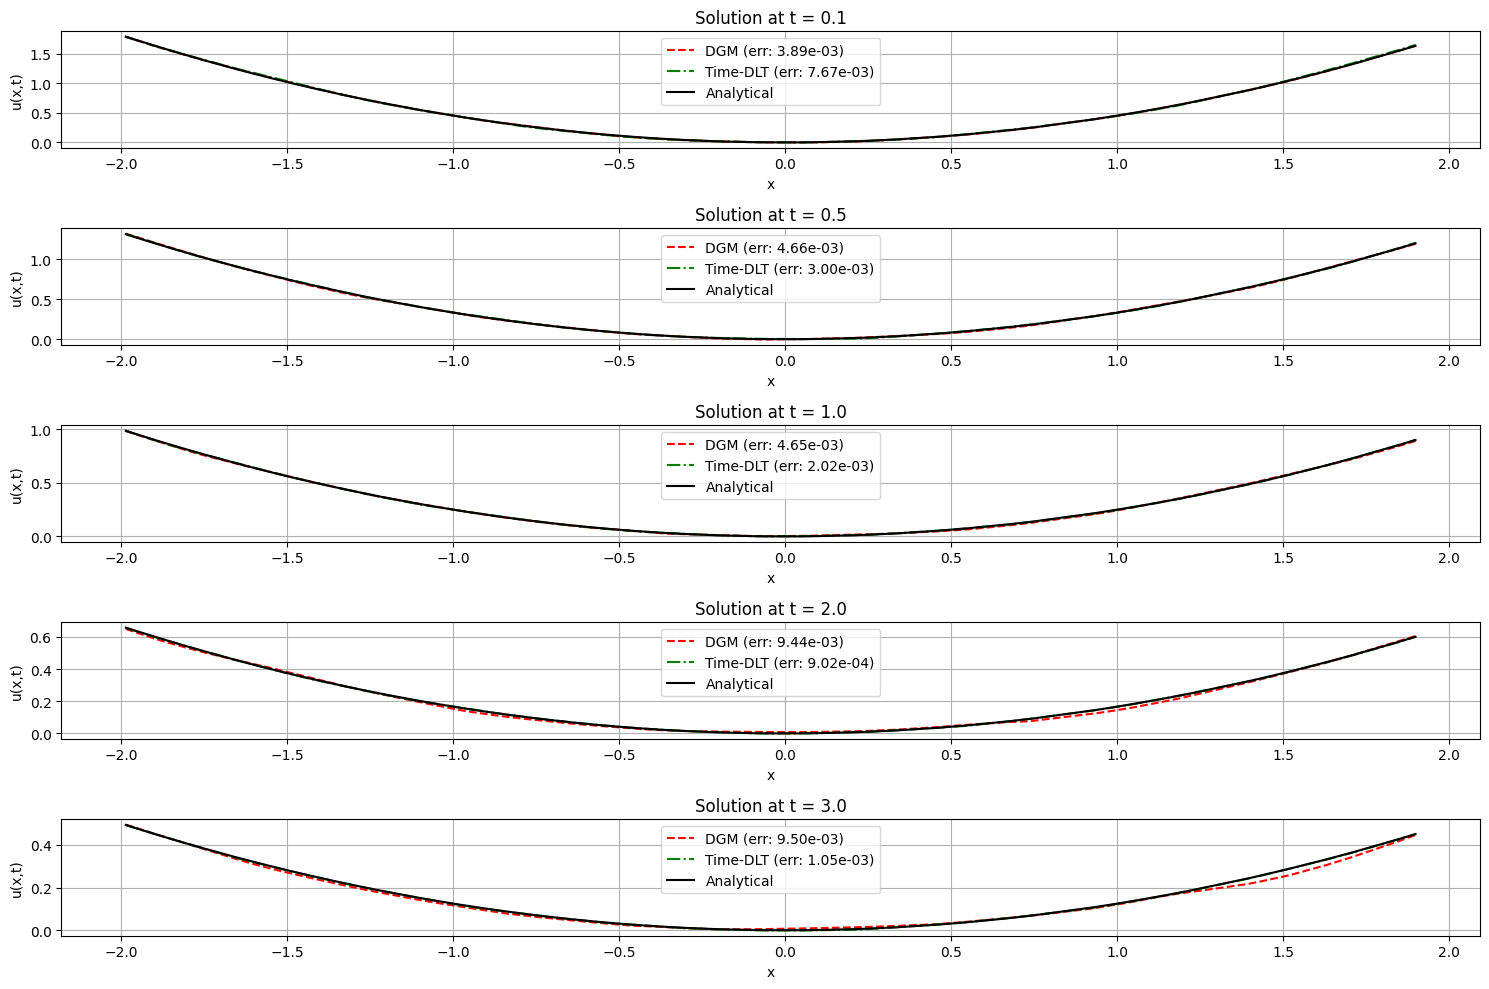


===== DATA VERIFICATION FOR PLOTTING =====
L2 Error Values (same as should appear in the table and plot):
| Index | Time | DGM L2 Error | Time-DLT L2 Error |
|-------|------|--------------|-------------------|
| 0 | 0.1 | 3.89e-03 | 7.67e-03 |
| 1 | 0.5 | 4.66e-03 | 3.00e-03 |
| 2 | 1.0 | 4.65e-03 | 2.02e-03 |
| 3 | 2.0 | 9.44e-03 | 9.02e-04 |
| 4 | 3.0 | 9.50e-03 | 1.05e-03 |

PDE Residual Values:
| Index | Time | DGM Residual | Time-DLT Residual |
|-------|------|--------------|-------------------|
| 0 | 0.1 | 4.18e-02 | 4.71e-01 |
| 1 | 0.5 | 2.63e-02 | 2.68e-01 |
| 2 | 1.0 | 1.69e-02 | 1.49e-01 |
| 3 | 2.0 | 1.28e-02 | 6.57e-02 |
| 4 | 3.0 | 7.24e-03 | 3.63e-02 |


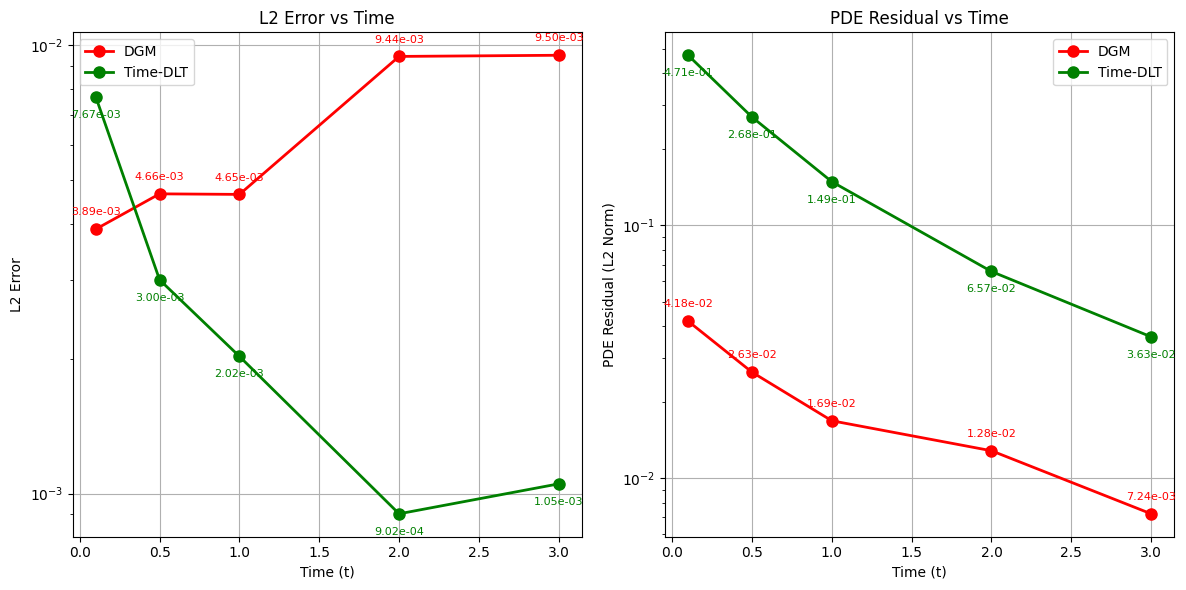

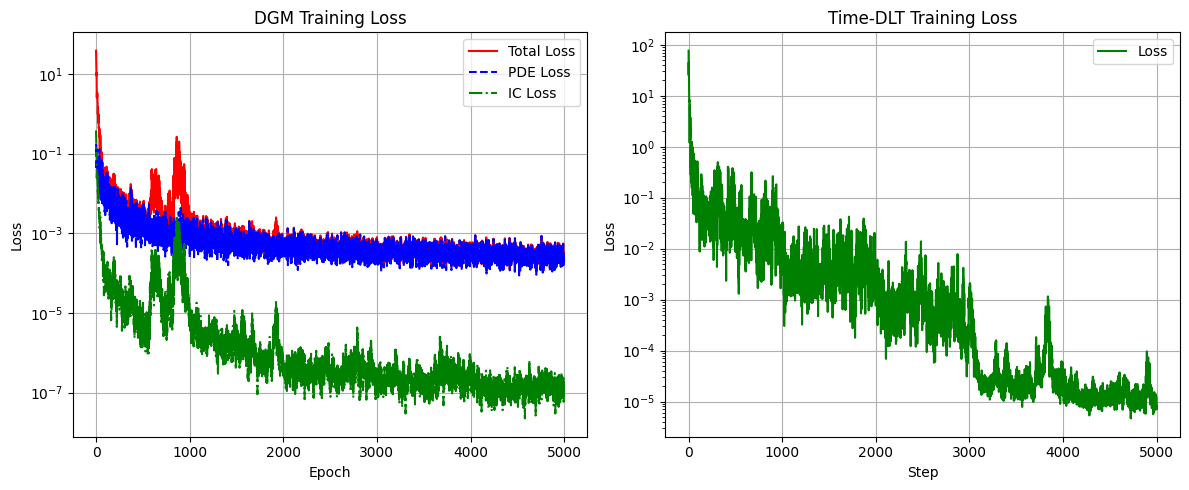

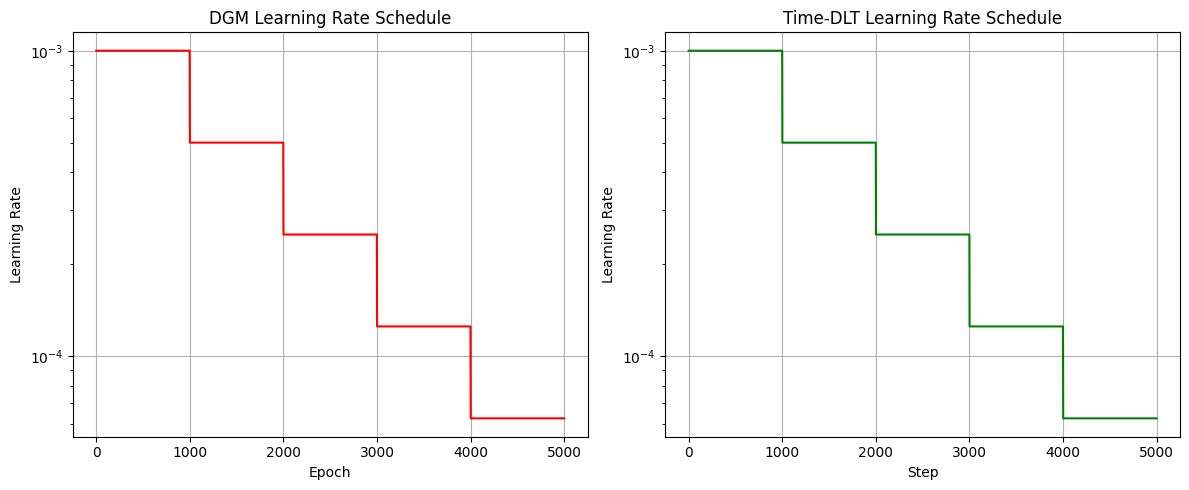


Running experiment with dimension d=2
Using network width: 148 for dimension 2
Hidden layers: [148, 148]

Solving with Deep Galerkin Method (DGM) using resnet architecture and standard sampling in [-2,2] × (0,T)...
Network configuration: width=148, depth=2, hidden layers=[148, 148]
Training DGM model for 5000 epochs with standard sampling in [-2,2] × (0,4.0)...
Initial condition weight: 100.0
Learning rate decay: step, decay rate: 0.5
  Step size: 1000


DGM Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed in 46.33 seconds
  Solving at t=0.1...
  Computing PDE residuals...
  Finished at t=0.1. Mean u(x,0.1) = 1.136165, Time: 0.00s
  L2 error vs analytical: 8.264662e-03
  PDE residual L2 error: 6.018359e-02
  Solving at t=0.5...
  Computing PDE residuals...
  Finished at t=0.5. Mean u(x,0.5) = 0.830645, Time: 0.00s
  L2 error vs analytical: 1.483012e-02
  PDE residual L2 error: 3.631892e-02
  Solving at t=1.0...
  Computing PDE residuals...
  Finished at t=1.0. Mean u(x,1.0) = 0.620327, Time: 0.00s
  L2 error vs analytical: 2.056006e-02
  PDE residual L2 error: 2.238491e-02
  Solving at t=2.0...
  Computing PDE residuals...
  Finished at t=2.0. Mean u(x,2.0) = 0.404096, Time: 0.00s
  L2 error vs analytical: 2.152937e-02
  PDE residual L2 error: 1.388759e-02
  Solving at t=3.0...
  Computing PDE residuals...
  Finished at t=3.0. Mean u(x,3.0) = 0.305061, Time: 0.00s
  L2 error vs analytical: 1.687910e-02
  PDE residual L2 error: 8.235231e-03

Solving with Time-Parameteri

Time-DLT Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training completed in 33.52 seconds
Final loss: 0.000295
  Solving at t=0.1...
  Computing PDE residuals...
  Finished at t=0.1. Mean u(x,0.1) = 1.141471, Time: 0.00s
  L2 error vs analytical: 1.617526e-02
  PDE residual L2 error: 6.667675e-01
  Solving at t=0.5...
  Computing PDE residuals...
  Finished at t=0.5. Mean u(x,0.5) = 0.836604, Time: 0.00s
  L2 error vs analytical: 9.214441e-03
  PDE residual L2 error: 3.327736e-01
  Solving at t=1.0...
  Computing PDE residuals...
  Finished at t=1.0. Mean u(x,1.0) = 0.626958, Time: 0.00s
  L2 error vs analytical: 5.924396e-03
  PDE residual L2 error: 2.011830e-01
  Solving at t=2.0...
  Computing PDE residuals...
  Finished at t=2.0. Mean u(x,2.0) = 0.417704, Time: 0.00s
  L2 error vs analytical: 4.117288e-03
  PDE residual L2 error: 8.466927e-02
  Solving at t=3.0...
  Computing PDE residuals...
  Finished at t=3.0. Mean u(x,3.0) = 0.312463, Time: 0.00s
  L2 error vs analytical: 3.141116e-03
  PDE residual L2 error: 4.807753e-02

Generat

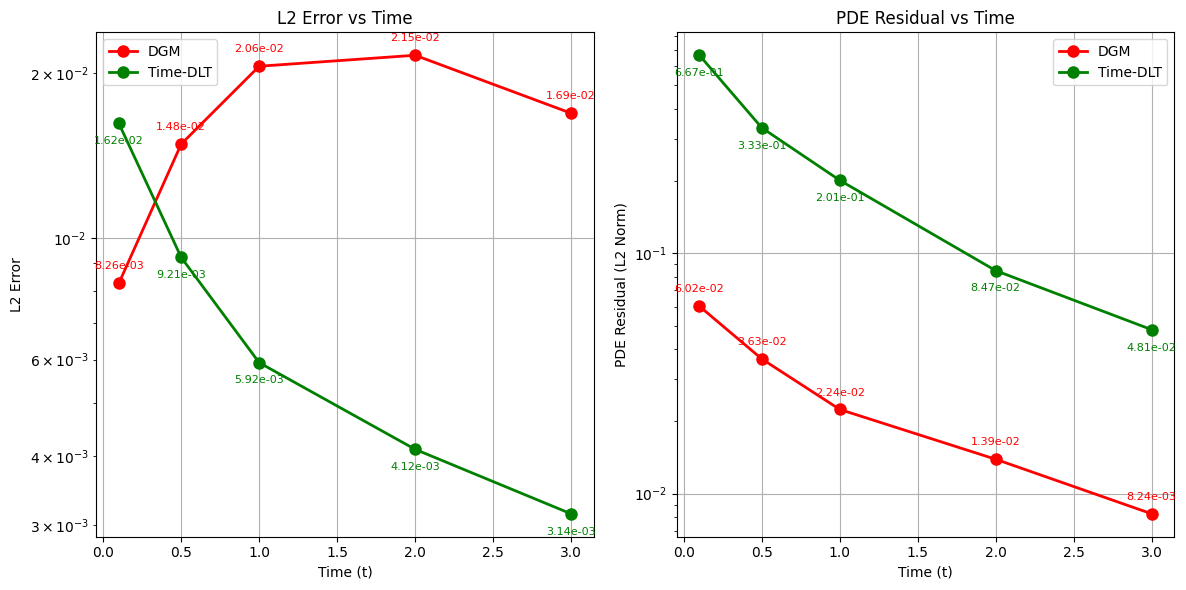

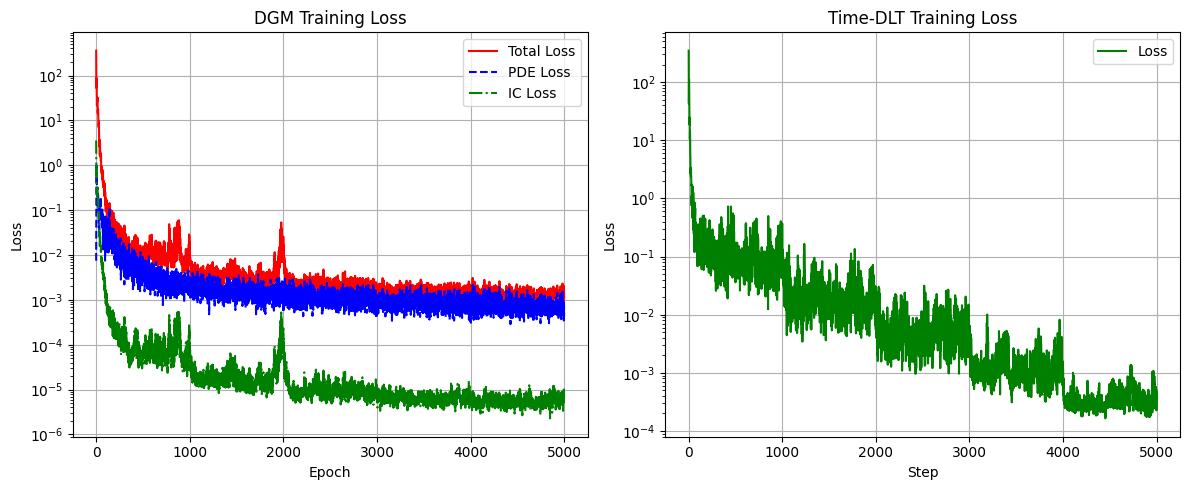

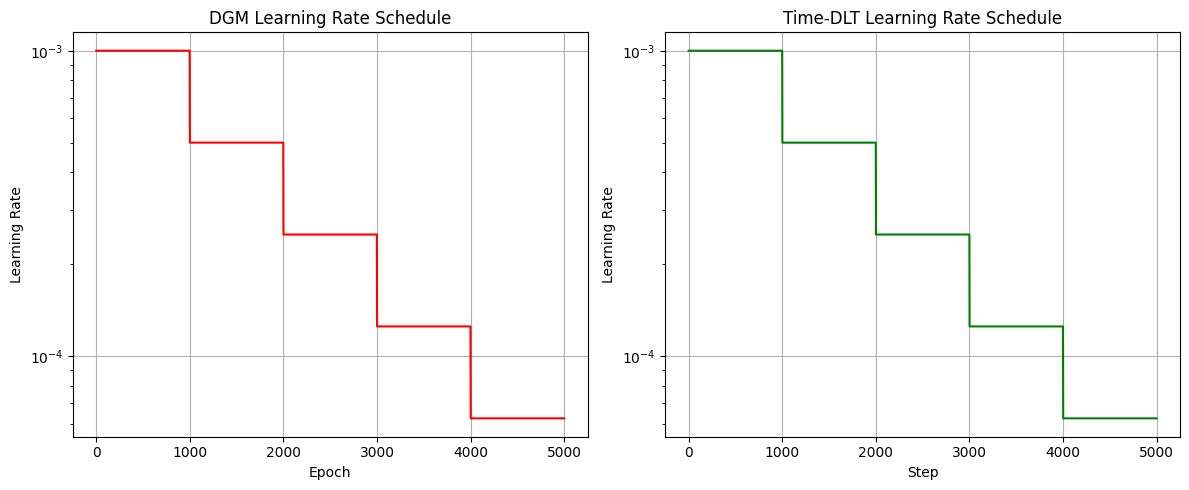


===== COMPARISON TABLE (DGM vs Time-DLT) =====
NOTE: In the table below, DGM results are in the FIRST error column
      Time-DLT results are in the SECOND error column


| d | Time | DGM L2 Error | Time-DLT L2 Error | DGM Train Time (s) | DLT Train Time (s) |
|---|------|-------------|-------------------|-------------------|-------------------|
| 1 | 0.1 | 3.89e-03 | 7.67e-03 | 43.03 | 31.37 |
| 1 | 0.5 | 4.66e-03 | 3.00e-03 |  |  |
| 1 | 1.0 | 4.65e-03 | 2.02e-03 |  |  |
| 1 | 2.0 | 9.44e-03 | 9.02e-04 |  |  |
| 1 | 3.0 | 9.50e-03 | 1.05e-03 |  |  |
| 2 | 0.1 | 8.26e-03 | 1.62e-02 | 44.24 | 33.52 |
| 2 | 0.5 | 1.48e-02 | 9.21e-03 |  |  |
| 2 | 1.0 | 2.06e-02 | 5.92e-03 |  |  |
| 2 | 2.0 | 2.15e-02 | 4.12e-03 |  |  |
| 2 | 3.0 | 1.69e-02 | 3.14e-03 |  |  |


Experiments completed successfully!

For more comprehensive experiments, you can modify these parameters:
- dimensions=[1, 2, 5, 10] to test higher dimensions
- Increase dgm_epochs and time_dlt_steps for better convergence
- Try different neural network architectures:
  * nn_width_base=64, 128, 256 for different base network widths
  * nn_width_factor=5, 10, 20 to control how width scales with dimension
  * nn_depth=2, 3, 4 for different network depths
- Try different learning rate decay schedules (step, plateau, cosine)
- Adjust dgm_ic_weight and dlt_ic_weight to control initial condition enforcement
- Test with enforce_ic=False to see performance without initial condition enforcement
- For complex high-dimensional cases, try use_approx_inverse=True


In [ ]:
def run_experiments_with_lr_decay(
    dimensions=[1], t_values=[0.1, 0.5, 1.0, 2.0],
    dgm_epochs=1000, time_dlt_steps=10000, num_test_points=100,
    dgm_network="resnet", dlt_network="resnet",
    nn_width_base=128, nn_width_factor=10, nn_depth=2,  # Modified for dimension-dependent width
    verbose=True, target_x_range=(-2.0, 2.0),
    run_dgm=True, run_time_dlt=True,
    use_approx_inverse=False,
    save_figures=True, figure_dir=None,
    memory_efficient=True,
    random_seed=42,
    dgm_ic_weight=100.0,
    dlt_ic_weight=100.0,
    enforce_ic=True,
    # Learning rate decay parameters
    dgm_lr_decay_type="none", dgm_lr_decay_rate=0.5, dgm_lr_decay_step=1000,
    dlt_lr_decay_type="none", dlt_lr_decay_rate=0.5, dlt_lr_decay_step=1000,
    lr_patience=500, lr_min=1e-6, lr_cooldown=0):
    """
    Run experiments comparing DGM and Time-DLT approaches with learning rate decay.

    Parameters:
        dimensions: List of dimensions to test
        t_values: List of time values to evaluate
        dgm_epochs: Number of epochs for DGM training
        time_dlt_steps: Number of steps for DLT training
        num_test_points: Number of test points for evaluation
        dgm_network: Network type for DGM ("mlp", "resnet")
        dlt_network: Network type for DLT ("mlp", "icnn", "resnet")
        nn_width: Width of hidden layers in the neural networks
        nn_depth: Number of hidden layers in the neural networks
        verbose: Whether to print progress
        target_x_range: Target x-range for inverse gradient sampling
        run_dgm: Whether to run DGM experiments
        run_time_dlt: Whether to run Time-DLT experiments
        use_approx_inverse: Whether to use approximate inverse gradient sampling
        save_figures: Whether to save figure outputs
        figure_dir: Directory to save figures (created if doesn't exist)
        memory_efficient: Whether to clear GPU cache between experiments to save memory
        random_seed: Random seed for reproducibility
        dgm_ic_weight: Weight for initial condition loss in DGM
        dlt_ic_weight: Weight for initial condition loss in DLT
        enforce_ic: Whether to enforce initial conditions during training

        # Learning rate decay parameters
        dgm_lr_decay_type: Type of learning rate decay for DGM ("step", "plateau", "cosine" or "none")
        dgm_lr_decay_rate: Factor by which the LR will be reduced for DGM
        dgm_lr_decay_step: Number of steps between LR decays for DGM with StepLR
        dlt_lr_decay_type: Type of learning rate decay for DLT ("step", "plateau", "cosine" or "none")
        dlt_lr_decay_rate: Factor by which the LR will be reduced for DLT
        dlt_lr_decay_step: Number of steps between LR decays for DLT with StepLR
        lr_patience: Number of epochs with no improvement for ReduceLROnPlateau
        lr_min: Minimum learning rate for all schedulers
        lr_cooldown: Number of epochs to wait before resuming normal operation after lr reduction

    Returns:
        Dictionary containing all experiment results.
    """
    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

    # Create figure directory if saving figures
    if save_figures and figure_dir is not None:
        os.makedirs(figure_dir, exist_ok=True)
        print(f"Saving figures to: {figure_dir}")

    # Store all results
    all_results = {}

    # Print experiment configuration with LR decay and neural network size
    print("\nExperiment Configuration:")
    print(f"- Dimensions: {dimensions}")
    print(f"- Time values: {t_values}")
    print(f"- DGM epochs: {dgm_epochs}")
    print(f"- Time-DLT steps: {time_dlt_steps}")
    print(f"- Neural Network: base_width={nn_width_base}, width_factor={nn_width_factor}, depth={nn_depth}")
    print(f"- Width formula: width = {nn_width_base} + {nn_width_factor} * dimension")
    print(f"- Target x-range: {target_x_range}")
    print(f"- Initial condition enforcement: {enforce_ic}")
    print(f"- DGM IC weight: {dgm_ic_weight}")
    print(f"- DLT IC weight: {dlt_ic_weight}")
    print(f"- Learning rate decay:")
    print(f"  - DGM: {dgm_lr_decay_type}, rate={dgm_lr_decay_rate}, step={dgm_lr_decay_step}")
    print(f"  - DLT: {dlt_lr_decay_type}, rate={dlt_lr_decay_rate}, step={dlt_lr_decay_step}")
    print(f"  - Shared: patience={lr_patience}, min_lr={lr_min}")
    print(f"- Random seed: {random_seed}")

    for d in dimensions:
        print(f"\n{'='*80}\nRunning experiment with dimension d={d}\n{'='*80}")

        # Calculate the dimension-dependent network width
        nn_width = nn_width_base + nn_width_factor * d
        hidden_layers = [nn_width] * nn_depth

        print(f"Using network width: {nn_width} for dimension {d}")
        print(f"Hidden layers: {hidden_layers}")

        # Create problem configuration
        config = ProblemConfig(dimension=d)

        # Generate test points in the range [-2,2]
        x_test = config.sample_domain((num_test_points, d), space='primal')

        # Store results for this dimension
        dimension_results = {
            "config": config,
            "x_test": x_test,
            "t_values": t_values,
            "analytical_solutions": {},
            "solvers": {},
        }

        # Compute analytical solutions
        for t in t_values:
            dimension_results["analytical_solutions"][t] = config.analytical_solution(x_test, t)

        # 1. Deep Galerkin Method (DGM) with standard sampling
        if run_dgm:
            print(f"\nSolving with Deep Galerkin Method (DGM) using {dgm_network} architecture and standard sampling in [-2,2] × (0,T)...")
            print(f"Network configuration: width={nn_width}, depth={nn_depth}, hidden layers={hidden_layers}")

            dgm_solver = DeepGalerkinMethod(
                config,
                hidden_layers=hidden_layers,  # Using the configurable hidden layers
                learning_rate=0.001,
                network_type=dgm_network,
                activation="relu",
                ic_weight=dgm_ic_weight,
                # LR decay parameters
                lr_decay_type=dgm_lr_decay_type,
                lr_decay_rate=dgm_lr_decay_rate,
                lr_decay_step=dgm_lr_decay_step,
                lr_patience=lr_patience,
                lr_min=lr_min,
                lr_cooldown=lr_cooldown
            )
            dgm_solver.train(
                epochs=dgm_epochs,
                batch_size=128*d,
                t_max=max(t_values) + 1.0,
                verbose=verbose,
                print_freq=max(1, dgm_epochs//10),
                enforce_ic=enforce_ic
            )

            dgm_results = {
                "u_values": {},
                "timings": {},
                "errors_vs_analytical": {},
                "pde_residuals": {},
                "training_time": sum(dgm_solver.history.get('loss_time', [0])),
                "training_loss": dgm_solver.history,
                "epochs": dgm_epochs,
                "network_type": dgm_network,
                "network_width": nn_width,
                "network_depth": nn_depth,
                "network_formula": f"{nn_width_base} + {nn_width_factor} * d",
                "hidden_layers": hidden_layers,
                "predict_fn": lambda x, t: dgm_solver.predict(x, t),
                "ic_weight": dgm_ic_weight,
                "enforce_ic": enforce_ic,
                "lr_decay_type": dgm_lr_decay_type,
                "lr_decay_rate": dgm_lr_decay_rate,
                "lr_decay_step": dgm_lr_decay_step
            }

            # Run DGM for each time value
            for t in t_values:
                print(f"  Solving at t={t}...")
                start_time = time.time()
                u_t = dgm_solver.predict(x_test, t)
                solve_time = time.time() - start_time

                # Store results
                dgm_results["u_values"][t] = u_t
                dgm_results["timings"][t] = solve_time
                dgm_results["errors_vs_analytical"][t] = compute_l2_error(u_t, dimension_results["analytical_solutions"][t])

                # Compute PDE residuals
                print(f"  Computing PDE residuals...")
                residuals = dgm_solver.compute_residuals(x_test, t)
                dgm_results["pde_residuals"][t] = residuals
                pde_error = torch.mean(residuals**2)**0.5

                print(f"  Finished at t={t}. Mean u(x,{t}) = {torch.mean(u_t):.6f}, Time: {solve_time:.2f}s")
                print(f"  L2 error vs analytical: {dgm_results['errors_vs_analytical'][t]:.6e}")
                print(f"  PDE residual L2 error: {pde_error:.6e}")

            dimension_results["solvers"][SolverType.DGM] = dgm_results

        # 2. Time-Parameterized DLT with inverse gradient sampling
        if run_time_dlt:
            sampling_method = "approximate inverse gradient" if use_approx_inverse else "exact inverse gradient"
            print(f"\nSolving with Time-Parameterized DLT using {dlt_network} architecture and {sampling_method} sampling targeting {target_x_range}...")
            print(f"Network configuration: width={nn_width}, depth={nn_depth}, hidden layers={hidden_layers}")

            try:
                time_dlt_solver = TimeParameterizedDLT(
                    config,
                    hidden_layers=hidden_layers,  # Using the configurable hidden layers
                    network_type=dlt_network,
                    activation="relu",
                    use_approx_inverse=use_approx_inverse,
                    approx_inverse_pretrain_steps=3000,
                    approx_inverse_finetune_steps=5000,
                    ic_weight=dlt_ic_weight,
                    # LR decay parameters
                    lr_decay_type=dlt_lr_decay_type,
                    lr_decay_rate=dlt_lr_decay_rate,
                    lr_decay_step=dlt_lr_decay_step,
                    lr_patience=lr_patience,
                    lr_min=lr_min,
                    lr_cooldown=lr_cooldown
                )

                # Train with the chosen inverse gradient sampling method
                time_dlt_solver.train(
                    steps=time_dlt_steps,
                    batch_size=128*d,
                    t_max=max(t_values) + 1.0,
                    verbose=verbose,
                    print_freq=max(1, time_dlt_steps//10),
                    target_x_range=target_x_range,
                    enforce_ic=enforce_ic
                )

                time_dlt_results = {
                    "u_values": {},
                    "timings": {},
                    "errors_vs_analytical": {},
                    "pde_residuals": {},
                    "training_time": time_dlt_solver.training_time,
                    "training_loss": time_dlt_solver.loss_history,
                    "dlt_loss_history": time_dlt_solver.dlt_loss_history,
                    "ic_loss_history": time_dlt_solver.ic_loss_history,
                    "lr_history": time_dlt_solver.lr_history,
                    "steps": time_dlt_steps,
                    "network_type": dlt_network,
                    "network_width": nn_width,
                    "network_depth": nn_depth,
                    "network_formula": f"{nn_width_base} + {nn_width_factor} * d",
                    "hidden_layers": hidden_layers,
                    "sampling_method": sampling_method,
                    "predict_fn": lambda x, t: time_dlt_solver.predict(x, t),
                    "ic_weight": dlt_ic_weight,
                    "enforce_ic": enforce_ic,
                    "lr_decay_type": dlt_lr_decay_type,
                    "lr_decay_rate": dlt_lr_decay_rate,
                    "lr_decay_step": dlt_lr_decay_step
                }

                # Run Time-Parameterized DLT for each time value
                for t in t_values:
                    print(f"  Solving at t={t}...")
                    start_time = time.time()
                    u_t = time_dlt_solver.predict(x_test, t)
                    solve_time = time.time() - start_time

                    # Store results
                    time_dlt_results["u_values"][t] = u_t
                    time_dlt_results["timings"][t] = solve_time
                    time_dlt_results["errors_vs_analytical"][t] = compute_l2_error(u_t, dimension_results["analytical_solutions"][t])

                    # Compute PDE residuals
                    print(f"  Computing PDE residuals...")
                    residuals = time_dlt_solver.compute_pde_residual(x_test, t)
                    time_dlt_results["pde_residuals"][t] = residuals
                    pde_error = torch.mean(residuals**2)**0.5

                    print(f"  Finished at t={t}. Mean u(x,{t}) = {torch.mean(u_t):.6f}, Time: {solve_time:.2f}s")
                    print(f"  L2 error vs analytical: {time_dlt_results['errors_vs_analytical'][t]:.6e}")
                    print(f"  PDE residual L2 error: {pde_error:.6e}")

                dimension_results["solvers"][SolverType.TIME_DLT] = time_dlt_results
            except Exception as e:
                print(f"Error with Time-DLT solver: {str(e)}")
                import traceback
                traceback.print_exc()

        # Store results for this dimension
        all_results[d] = dimension_results

        # Generate plots for this dimension
        print("\nGenerating plots...")

        dgm_solver_results = dimension_results["solvers"].get(SolverType.DGM)
        time_dlt_solver_results = dimension_results["solvers"].get(SolverType.TIME_DLT)

        # Print verification of error values before plotting
        print("\nVerification of error values directly from results dictionary:")
        print("| Time | DGM L2 Error | Time-DLT L2 Error |")
        print("|------|--------------|-------------------|")
        for t in t_values:
            dgm_err = dgm_solver_results["errors_vs_analytical"][t] if dgm_solver_results else float('nan')
            dlt_err = time_dlt_solver_results["errors_vs_analytical"][t] if time_dlt_solver_results else float('nan')
            print(f"| {t:.1f} | {dgm_err:.2e} | {dlt_err:.2e} |")

        # Plot solutions
        if d == 1:
            fig = plot_solutions_1d(config, x_test, t_values, dgm_solver_results, time_dlt_solver_results)
            if save_figures and figure_dir is not None:
                fig.savefig(f"{figure_dir}/hamilton_jacobi_solutions_1d_d{d}_width{nn_width}.png", dpi=300, bbox_inches='tight')
            plt.show()

        # Plot error vs time
        fig_error = plot_error_vs_time(t_values, dgm_solver_results, time_dlt_solver_results)
        if save_figures and figure_dir is not None:
            fig_error.savefig(f"{figure_dir}/hamilton_jacobi_errors_d{d}_width{nn_width}.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Plot training loss
        fig_loss = plot_training_loss(dgm_solver_results, time_dlt_solver_results)
        if save_figures and figure_dir is not None:
            fig_loss.savefig(f"{figure_dir}/hamilton_jacobi_training_loss_d{d}_width{nn_width}.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Plot learning rate history
        fig_lr = plot_learning_rate_history(dgm_solver_results, time_dlt_solver_results)
        if save_figures and figure_dir is not None:
            fig_lr.savefig(f"{figure_dir}/hamilton_jacobi_lr_history_d{d}_width{nn_width}.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Clear some memory if needed
        if memory_efficient and torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Print summary table
    print_comparison_table(all_results)

    return all_results

def main():
    """Run experiments for the Hamilton-Jacobi equation comparing DGM and Time-DLT approaches."""
    print("\nHAMILTON-JACOBI EXPERIMENTS WITH PYTORCH AUTODIFF")
    print("=" * 80)
    print("Comparing against analytical solution: u(x,t) = x²/2(1+t)")
    print("Using two methods with different sampling strategies:")
    print("1. DGM: Standard sampling in Q = [-2,2] × (0,T)")
    print("2. Time-DLT: Inverse gradient sampling targeting x-range [-2,2]")
    print(f"Using device: {device}")
    print("=" * 80)

    # Create output directory for figures
    output_dir = "hj_outputs"
    os.makedirs(output_dir, exist_ok=True)

    # Set a fixed random seed for reproducibility
    fixed_seed = 43

    # Run experiments with learning rate decay and configurable neural network size
    all_results = run_experiments_with_lr_decay(
        dimensions=[1, 2],                      # Test in 1D and 2D
        t_values=[0.1, 0.5, 1.0, 2.0, 3.0],     # Test multiple time points
        dgm_epochs=5000,                        # Number of epochs for DGM
        time_dlt_steps=5000,                    # Number of steps for DLT
        dgm_network="resnet",                   # Use ResNet for DGM
        dlt_network="resnet",                   # Use ResNet for Time-DLT
        nn_width_base=128,                      # Base width of hidden layers
        nn_width_factor=10,                     # Dimension-dependent factor
        nn_depth=2,                             # Number of hidden layers
        verbose=True,
        run_dgm=True,                           # Run DGM experiments
        run_time_dlt=True,                      # Run Time-DLT experiments
        target_x_range=(-2.0, 2.0),             # Target x-range for inverse gradient sampling
        use_approx_inverse=False,               # Use exact inverse gradient sampling
        save_figures=True,                      # Save figures to output directory
        figure_dir=output_dir,                  # Directory to save figures
        memory_efficient=True,                  # Clear GPU memory between runs
        random_seed=fixed_seed,                 # Use fixed seed for reproducibility
        dgm_ic_weight=100.0,                    # Weight for initial condition in DGM
        dlt_ic_weight=100.0,                    # Weight for initial condition in DLT
        enforce_ic=True,                        # Enable initial condition enforcement

        # Learning rate decay parameters
        dgm_lr_decay_type="step",               # Step decay for DGM
        dgm_lr_decay_rate=0.5,                  # Reduce LR by half
        dgm_lr_decay_step=1000,                 # Every 1000 epochs
        dlt_lr_decay_type="step",               # Step decay for DLT
        dlt_lr_decay_rate=0.5,                  # Reduce LR by half
        dlt_lr_decay_step=1000,                 # Every 1000 steps
        lr_patience=500,                        # For plateau scheduler
        lr_min=1e-6                             # Minimum learning rate
    )

    print("\nExperiments completed successfully!")

    # Print recommendations for more comprehensive experiments
    print("\nFor more comprehensive experiments, you can modify these parameters:")
    print("- dimensions=[1, 2, 5, 10] to test higher dimensions")
    print("- Increase dgm_epochs and time_dlt_steps for better convergence")
    print("- Try different neural network architectures:")
    print("  * nn_width_base=64, 128, 256 for different base network widths")
    print("  * nn_width_factor=5, 10, 20 to control how width scales with dimension")
    print("  * nn_depth=2, 3, 4 for different network depths")
    print("- Try different learning rate decay schedules (step, plateau, cosine)")
    print("- Adjust dgm_ic_weight and dlt_ic_weight to control initial condition enforcement")
    print("- Test with enforce_ic=False to see performance without initial condition enforcement")
    print("- For complex high-dimensional cases, try use_approx_inverse=True")

    return all_results

if __name__ == "__main__":
    main()

## Run batch version:

In [ ]:
def generate_nips_latex_table(multi_run_stats):
    """
    Generate a NIPS-style LaTeX table with grouped columns for DGM and DLT.

    Args:
        multi_run_stats: Dictionary containing statistical information from multiple runs

    Returns:
        LaTeX code for the table
    """
    # Extract unique dimensions and times
    dimensions = sorted(list(set(key[0] for key in multi_run_stats.keys())))
    times = sorted(list(set(key[1] for key in multi_run_stats.keys())))

    # Start building LaTeX table
    latex_code = [
        "\\begin{table}[htbp]",
        "  \\caption{Comparison of DGM and DLT methods across dimensions and time horizons}",
        "  \\label{tab:dgm-dlt-comparison}",
        "  \\centering",
        "  \\resizebox{\\textwidth}{!}{",
        "  \\begin{tabular}{cc|ccc|ccc|cc}",
        "    \\toprule",
        "    & & \\multicolumn{3}{c|}{DGM} & \\multicolumn{3}{c|}{DLT} & \\multicolumn{2}{c}{Ratio DGM/DLT} \\\\",
        "    $d$ & $t$ & L2 Error & PDE Residual & Runtime (s) & L2 Error & PDE Residual & Runtime (s) & Mean Ratio & $\\sigma$ \\\\",
        "    \\midrule"
    ]

    # Add data rows
    for d in dimensions:
        first_row = True
        for t in times:
            key = (d, t)
            if key not in multi_run_stats:
                continue

            stats = multi_run_stats[key]

            # Extract statistics
            mean_dgm_l2 = stats.get("mean_dgm_l2_error", float('nan'))
            mean_dlt_l2 = stats.get("mean_dlt_l2_error", float('nan'))
            mean_dgm_residual = stats.get("mean_dgm_residual", float('nan'))
            mean_dlt_residual = stats.get("mean_dlt_residual", float('nan'))

            # Calculate L2 error ratio (DGM/DLT)
            if mean_dlt_l2 > 0:
                l2_ratio = mean_dgm_l2 / mean_dlt_l2
            else:
                l2_ratio = float('nan')

            # Calculate standard deviation of L2 error ratio
            if len(stats.get("dgm_l2_errors", [])) > 0 and len(stats.get("dlt_l2_errors", [])) > 0:
                # Calculate ratio for each run
                l2_ratios = []
                for dgm_err, dlt_err in zip(stats["dgm_l2_errors"], stats["dlt_l2_errors"]):
                    if dlt_err > 0:
                        l2_ratios.append(dgm_err / dlt_err)

                if l2_ratios:
                    sigma_l2_ratio = np.std(l2_ratios)
                else:
                    sigma_l2_ratio = float('nan')
            else:
                sigma_l2_ratio = float('nan')

            # Get runtimes (might not be available in all statistical data)
            dgm_runtime = stats.get("mean_dgm_runtime", "-")
            dlt_runtime = stats.get("mean_dlt_runtime", "-")

            # Format each value with scientific notation for small numbers
            dgm_l2_str = f"{mean_dgm_l2:.2e}"
            dlt_l2_str = f"{mean_dlt_l2:.2e}"
            dgm_res_str = f"{mean_dgm_residual:.2e}"
            dlt_res_str = f"{mean_dlt_residual:.2e}"

            # Apply row styling if this is the first row of a dimension group
            if first_row and d > dimensions[0]:
                # Add a small gap before new dimension group
                latex_code.append("    \\midrule")
                first_row = False
            elif first_row:
                first_row = False

            # Add the data row
            latex_code.append(f"    {d} & {t:.1f} & {dgm_l2_str} & {dgm_res_str} & {dgm_runtime} & {dlt_l2_str} & {dlt_res_str} & {dlt_runtime} & {l2_ratio:.2f} & {sigma_l2_ratio:.2f} \\\\")

    # Finish the table
    latex_code.extend([
        "    \\bottomrule",
        "  \\end{tabular}",
        "  }",
        "\\end{table}"
    ])

    return "\n".join(latex_code)


def print_comparison_table_with_l2_ratio(multi_run_stats):
    """
    Print a comparison table with L2 error ratios (DGM/DLT).

    Args:
        multi_run_stats: Dictionary containing statistical information from multiple runs
    """
    if IN_COLAB:
        from IPython.display import display, Markdown

    table_rows = []
    header = "| d | t | Mean DGM L2 Error | Mean DLT L2 Error | PDE Residual DGM | PDE Residual DLT | L2 Ratio (DGM/DLT) | σ Ratio |"
    separator = "|---|---|-----------------|-------------------|-----------------|-----------------|-------------------|---------|"
    table_rows.append(header)
    table_rows.append(separator)

    # Collect all dimensions and times
    all_dims = sorted(list(set(key[0] for key in multi_run_stats.keys())))
    all_times = sorted(list(set(key[1] for key in multi_run_stats.keys())))

    # Print rows
    for d in all_dims:
        for t in all_times:
            key = (d, t)
            if key not in multi_run_stats:
                continue

            stats = multi_run_stats[key]

            # Extract statistics
            mean_dgm_l2 = stats.get("mean_dgm_l2_error", float('nan'))
            mean_dlt_l2 = stats.get("mean_dlt_l2_error", float('nan'))
            mean_dgm_residual = stats.get("mean_dgm_residual", float('nan'))
            mean_dlt_residual = stats.get("mean_dlt_residual", float('nan'))

            # Calculate L2 error ratio (DGM/DLT)
            if mean_dlt_l2 > 0:
                l2_ratio = mean_dgm_l2 / mean_dlt_l2
            else:
                l2_ratio = float('nan')

            # Calculate standard deviation of L2 error ratio
            if len(stats.get("dgm_l2_errors", [])) > 0 and len(stats.get("dlt_l2_errors", [])) > 0:
                # Calculate ratio for each run
                l2_ratios = []
                for dgm_err, dlt_err in zip(stats["dgm_l2_errors"], stats["dlt_l2_errors"]):
                    if dlt_err > 0:
                        l2_ratios.append(dgm_err / dlt_err)

                if l2_ratios:
                    sigma_l2_ratio = np.std(l2_ratios)
                else:
                    sigma_l2_ratio = float('nan')
            else:
                sigma_l2_ratio = float('nan')

            # Add row
            row = f"| {d} | {t} | {mean_dgm_l2:.2e} | {mean_dlt_l2:.2e} | {mean_dgm_residual:.2e} | {mean_dlt_residual:.2e} | {l2_ratio:.2f} | {sigma_l2_ratio:.2f} |"
            table_rows.append(row)

    # Convert to string
    table_str = "\n".join(table_rows)

    # Print the heading
    print("\n===== COMPARISON WITH L2 ERROR RATIO (DGM/DLT) =====")

    # Use IPython display for Colab
    if IN_COLAB:
        display(Markdown(table_str))
    else:
        print("\n" + table_str + "\n")

    return table_str


def plot_l2_error_ratio_statistics(multi_run_stats, figsize=(12, 8)):
    """
    Plot the mean and standard deviation of the L2 error ratio (DGM/DLT) across multiple runs.

    Args:
        multi_run_stats: Dictionary containing statistical information from multiple runs
        figsize: Figure size for the plot
    """
    plt.figure(figsize=figsize)

    # Extract unique dimensions and times
    dimensions = sorted(list(set(key[0] for key in multi_run_stats.keys())))
    times = sorted(list(set(key[1] for key in multi_run_stats.keys())))

    # Set up the plot with one subplot per dimension
    num_dims = len(dimensions)

    for i, d in enumerate(dimensions):
        plt.subplot(num_dims, 1, i + 1)

        # Collect data for this dimension
        dim_times = []
        mean_ratios = []
        sigma_ratios = []

        for t in times:
            key = (d, t)
            if key in multi_run_stats:
                stats = multi_run_stats[key]

                # Calculate L2 error ratio (DGM/DLT)
                mean_dgm_l2 = stats.get("mean_dgm_l2_error", float('nan'))
                mean_dlt_l2 = stats.get("mean_dlt_l2_error", float('nan'))

                if mean_dlt_l2 > 0:
                    l2_ratio = mean_dgm_l2 / mean_dlt_l2
                else:
                    l2_ratio = float('nan')

                # Calculate standard deviation of L2 error ratio
                if len(stats.get("dgm_l2_errors", [])) > 0 and len(stats.get("dlt_l2_errors", [])) > 0:
                    # Calculate ratio for each run
                    l2_ratios = []
                    for dgm_err, dlt_err in zip(stats["dgm_l2_errors"], stats["dlt_l2_errors"]):
                        if dlt_err > 0:
                            l2_ratios.append(dgm_err / dlt_err)

                    if l2_ratios:
                        sigma_l2_ratio = np.std(l2_ratios)
                    else:
                        sigma_l2_ratio = float('nan')
                else:
                    sigma_l2_ratio = float('nan')

                dim_times.append(t)
                mean_ratios.append(l2_ratio)
                sigma_ratios.append(sigma_l2_ratio)

        # Convert to numpy arrays
        mean_ratios = np.array(mean_ratios)
        sigma_ratios = np.array(sigma_ratios)

        # Plot mean ratio with error bars
        plt.errorbar(dim_times, mean_ratios, yerr=sigma_ratios, fmt='o-', capsize=5, linewidth=2,
                    markersize=8, label=f'L2 Error Ratio (DGM/DLT)')

        # Add a horizontal line at y=1 (where both methods have equal L2 errors)
        plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Equal L2 Errors')

        # Annotate points with mean and sigma values
        for j, (t, mean, sigma) in enumerate(zip(dim_times, mean_ratios, sigma_ratios)):
            plt.annotate(f"{mean:.2f}±{sigma:.2f}", (t, mean),
                         textcoords="offset points", xytext=(0,10),
                         ha='center', fontsize=9)

        plt.title(f'Dimension d={d}: L2 Error Ratio (DGM/DLT) Statistics')
        plt.xlabel('Time (t)')
        plt.ylabel('L2 Error Ratio')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    return plt.gcf()


def run_multiple_experiments(
    num_runs=10,
    dimensions=[1, 2],
    t_values=[0.1, 0.5, 1.0, 2.0],
    dgm_epochs=1000,
    time_dlt_steps=1000,
    verbose=True,
    **kwargs
):
    """
    Run multiple experiments to collect statistics on the performance of DGM vs Time-DLT.

    Args:
        num_runs: Number of independent runs to perform
        dimensions: List of dimensions to test
        t_values: List of time values to evaluate
        dgm_epochs: Number of epochs for DGM training
        time_dlt_steps: Number of steps for DLT training
        verbose: Whether to print progress information
        **kwargs: Additional arguments to pass to run_experiments_with_lr_decay

    Returns:
        Dictionary containing statistical information from multiple runs
    """
    print(f"\nRunning {num_runs} independent experiments for statistical analysis...")

    # Dictionary to store all results across runs
    all_runs_results = []

    # Dictionary to collect statistics
    multi_run_stats = {}

    # Initialize structures to collect results
    for d in dimensions:
        for t in t_values:
            key = (d, t)
            multi_run_stats[key] = {
                "dgm_l2_errors": [],
                "dlt_l2_errors": [],
                "dgm_residuals": [],
                "dlt_residuals": [],
                "dgm_runtimes": [],
                "dlt_runtimes": [],
                "residual_ratios": [],
                "l2_ratios": []
            }

    # Set a different random seed for each run, but derived from the base seed for reproducibility
    base_seed = kwargs.get('random_seed', 42)

    # Run the experiments multiple times
    for run in range(num_runs):
        # Set derived random seed for this run
        run_seed = base_seed + run

        print(f"\n{'='*80}\nStarting run {run+1}/{num_runs} with seed {run_seed}\n{'='*80}")

        # Run the experiment with the derived seed
        run_results = run_experiments_with_lr_decay(
            dimensions=dimensions,
            t_values=t_values,
            dgm_epochs=dgm_epochs,
            time_dlt_steps=time_dlt_steps,
            verbose=verbose,
            random_seed=run_seed,
            **{k: v for k, v in kwargs.items() if k != 'random_seed'}
        )

        # Store the full results for this run
        all_runs_results.append(run_results)

        # Extract and store metrics for statistical analysis
        for d in dimensions:
            if d not in run_results:
                continue

            dim_results = run_results[d]
            for t in t_values:
                if t not in dim_results["t_values"]:
                    continue

                key = (d, t)
                dgm_results = dim_results["solvers"].get(SolverType.DGM)
                time_dlt_results = dim_results["solvers"].get(SolverType.TIME_DLT)

                if dgm_results and time_dlt_results:
                    # L2 errors
                    dgm_l2_error = dgm_results["errors_vs_analytical"][t]
                    dlt_l2_error = time_dlt_results["errors_vs_analytical"][t]

                    multi_run_stats[key]["dgm_l2_errors"].append(dgm_l2_error)
                    multi_run_stats[key]["dlt_l2_errors"].append(dlt_l2_error)

                    # Calculate and store the L2 error ratio (DGM/DLT)
                    if dlt_l2_error > 0:
                        l2_ratio = dgm_l2_error / dlt_l2_error
                        multi_run_stats[key]["l2_ratios"].append(l2_ratio)

                    # PDE residuals (take mean squared value for each field point)
                    dgm_residual = torch.mean(dgm_results["pde_residuals"][t]**2).sqrt().item()
                    dlt_residual = torch.mean(time_dlt_results["pde_residuals"][t]**2).sqrt().item()

                    multi_run_stats[key]["dgm_residuals"].append(dgm_residual)
                    multi_run_stats[key]["dlt_residuals"].append(dlt_residual)

                    # Store runtimes
                    if "timings" in dgm_results and t in dgm_results["timings"]:
                        multi_run_stats[key]["dgm_runtimes"].append(dgm_results["timings"][t])
                    if "timings" in time_dlt_results and t in time_dlt_results["timings"]:
                        multi_run_stats[key]["dlt_runtimes"].append(time_dlt_results["timings"][t])

                    # Calculate and store the ratio of residuals (DGM/DLT)
                    if dlt_residual > 0:  # Avoid division by zero
                        residual_ratio = dgm_residual / dlt_residual
                        multi_run_stats[key]["residual_ratios"].append(residual_ratio)
                    else:
                        # If DLT residual is zero, don't include this in ratio calculations
                        print(f"Warning: DLT residual is zero for d={d}, t={t}, run={run+1}")

    # Calculate statistics across all runs
    for key in multi_run_stats:
        stats = multi_run_stats[key]

        # Only calculate statistics if we have data
        if stats["dgm_l2_errors"] and stats["dlt_l2_errors"]:
            # Calculate mean L2 errors
            stats["mean_dgm_l2_error"] = np.mean(stats["dgm_l2_errors"])
            stats["mean_dlt_l2_error"] = np.mean(stats["dlt_l2_errors"])

            # Calculate standard deviation of L2 errors
            stats["sigma_dgm_l2_error"] = np.std(stats["dgm_l2_errors"])
            stats["sigma_dlt_l2_error"] = np.std(stats["dlt_l2_errors"])

            # Calculate mean L2 error ratio
            if stats["l2_ratios"]:
                stats["mean_l2_ratio"] = np.mean(stats["l2_ratios"])
                stats["sigma_l2_ratio"] = np.std(stats["l2_ratios"])
            else:
                stats["mean_l2_ratio"] = float('nan')
                stats["sigma_l2_ratio"] = float('nan')

            # Calculate mean residuals
            stats["mean_dgm_residual"] = np.mean(stats["dgm_residuals"])
            stats["mean_dlt_residual"] = np.mean(stats["dlt_residuals"])

            # Calculate mean and standard deviation of residual ratio
            if stats["residual_ratios"]:
                stats["mean_residual_ratio"] = np.mean(stats["residual_ratios"])
                stats["sigma_residual_ratio"] = np.std(stats["residual_ratios"])
            else:
                stats["mean_residual_ratio"] = float('nan')
                stats["sigma_residual_ratio"] = float('nan')

            # Calculate mean runtimes
            if stats["dgm_runtimes"]:
                stats["mean_dgm_runtime"] = np.mean(stats["dgm_runtimes"])
            if stats["dlt_runtimes"]:
                stats["mean_dlt_runtime"] = np.mean(stats["dlt_runtimes"])

    print("\nStatistical analysis complete!")

    return multi_run_stats, all_runs_results


# Modified main function to use the new table and plotting functions
def main():
    """Run experiments for the Hamilton-Jacobi equation comparing DGM and Time-DLT approaches."""
    print("\nHAMILTON-JACOBI EXPERIMENTS WITH PYTORCH AUTODIFF")
    print("=" * 80)
    print("Comparing against analytical solution: u(x,t) = x²/2(1+t)")
    print("Using two methods with different sampling strategies:")
    print("1. DGM: Standard sampling in Q = [-2,2] × (0,T)")
    print("2. Time-DLT: Inverse gradient sampling targeting x-range [-2,2]")
    print(f"Using device: {device}")
    print("=" * 80)

    # Create output directory for figures
    output_dir = "hj_outputs"
    os.makedirs(output_dir, exist_ok=True)

    # Set a fixed random seed for reproducibility
    fixed_seed = 43

    # Define whether to run multiple experiments for statistics
    run_multiple = True
    num_runs = 10

    if run_multiple:
        print(f"\nRunning multiple experiments ({num_runs} times) to collect statistics...")

        # Reduced epochs/steps for multiple runs to save time
        multi_run_stats, all_results = run_multiple_experiments(
            num_runs=num_runs,
            dimensions=[2,5,10,20,30],                      # Test in 1D and 2D
            t_values=[0.1, 0.5, 1.0, 2.0],          # Test multiple time points
            dgm_epochs=10000,                        # Reduced epochs for faster runs
            time_dlt_steps=10000,                    # Reduced steps for faster runs
            verbose=False,                          # Reduce output verbosity for multiple runs
            num_test_points=100,
            dgm_network="resnet",                   # Use ResNet for DGM
            dlt_network="resnet",                   # Use ResNet for Time-DLT
            nn_width_base=128,                      # Base width of hidden layers
            nn_width_factor=10,                     # Dimension-dependent factor
            nn_depth=2,                             # Number of hidden layers
            run_dgm=True,                           # Run DGM experiments
            run_time_dlt=True,                      # Run Time-DLT experiments
            target_x_range=(-2.0, 2.0),             # Target x-range for inverse gradient sampling
            use_approx_inverse=False,               # Use exact inverse gradient sampling
            save_figures=False,                     # Don't save figures for every run
            figure_dir=output_dir,                  # Directory to save figures
            memory_efficient=True,                  # Clear GPU memory between runs
            random_seed=fixed_seed,                 # Base seed for reproducibility
            dgm_ic_weight=100.0,                    # Weight for initial condition in DGM
            dlt_ic_weight=0.0,                      # Weight for initial condition in DLT
            enforce_ic=True,                        # Enable initial condition enforcement

            # Learning rate decay parameters - simpler settings for multiple runs
            dgm_lr_decay_type="step",               # Step decay for DGM
            dgm_lr_decay_rate=0.5,                  # Reduce LR by half
            dgm_lr_decay_step=500,                  # Every 500 epochs
            dlt_lr_decay_type="step",               # Step decay for DLT
            dlt_lr_decay_rate=0.5,                  # Reduce LR by half
            dlt_lr_decay_step=500,                  # Every 500 steps
            lr_patience=200,                        # For plateau scheduler
            lr_min=1e-6                             # Minimum learning rate
        )

        # Print new comparison table with L2 error ratio
        print_comparison_table_with_l2_ratio(multi_run_stats)

        # Generate and print NIPS-style LaTeX table
        latex_table = generate_nips_latex_table(multi_run_stats)
        print("\nNIPS-style LaTeX Table:")
        print(latex_table)

        # Plot L2 error ratio statistics
        fig_ratio = plot_l2_error_ratio_statistics(multi_run_stats)
        if output_dir:
            fig_ratio.savefig(f"{output_dir}/l2_error_ratio_statistics.png", dpi=300, bbox_inches='tight')
        plt.show()

        print("\nMulti-run statistical analysis completed!")

    else:
        # Single comprehensive run with more epochs/steps
        print("\nRunning a single comprehensive experiment...")

        # Run experiments with learning rate decay
        all_results = run_experiments_with_lr_decay(
            dimensions=[2,5,10,20,30],                      # Test in 1D and 2D
            t_values=[0.1, 0.5, 1.0, 2.0, 3.0],     # Test multiple time points
            dgm_epochs=10000,                        # Number of epochs for DGM
            time_dlt_steps=10000,                    # Number of steps for DLT
            dgm_network="resnet",                   # Use ResNet for DGM
            dlt_network="resnet",                   # Use ResNet for Time-DLT
            nn_width_base=128,                      # Base width of hidden layers
            nn_width_factor=10,                     # Dimension-dependent factor
            nn_depth=2,                             # Number of hidden layers
            verbose=True,
            run_dgm=True,                           # Run DGM experiments
            run_time_dlt=True,                      # Run Time-DLT experiments
            target_x_range=(-2.0, 2.0),             # Target x-range for inverse gradient sampling
            use_approx_inverse=False,               # Use exact inverse gradient sampling
            save_figures=True,                      # Save figures to output directory
            figure_dir=output_dir,                  # Directory to save figures
            memory_efficient=True,                  # Clear GPU memory between runs
            random_seed=fixed_seed,                 # Use fixed seed for reproducibility
            dgm_ic_weight=100.0,                    # Weight for initial condition in DGM
            dlt_ic_weight=0.0,                    # Weight for initial condition in DLT
            enforce_ic=True,                        # Enable initial condition enforcement

            # Learning rate decay parameters
            dgm_lr_decay_type="step",               # Step decay for DGM
            dgm_lr_decay_rate=0.5,                  # Reduce LR by half
            dgm_lr_decay_step=1000,                 # Every 1000 epochs
            dlt_lr_decay_type="step",               # Step decay for DLT
            dlt_lr_decay_rate=0.5,                  # Reduce LR by half
            dlt_lr_decay_step=1000,                 # Every 1000 steps
            lr_patience=500,                        # For plateau scheduler
            lr_min=1e-6                             # Minimum learning rate
        )

        print("\nExperiment completed successfully!")

    # Print recommendations for more comprehensive experiments
    print("\nFor more comprehensive experiments, you can modify these parameters:")
    print("- dimensions=[1, 2, 5, 10] to test higher dimensions")
    print("- Increase dgm_epochs and time_dlt_steps for better convergence")
    print("- Try different learning rate decay schedules (step, plateau, cosine)")
    print("- Adjust dgm_ic_weight and dlt_ic_weight to control initial condition enforcement")
    print("- Test with enforce_ic=False to see performance without initial condition enforcement")
    print("- For complex high-dimensional cases, try use_approx_inverse=True")
    print("- Modify num_runs to control the number of experiments for statistical analysis")

    if run_multiple:
        return multi_run_stats, all_results
    else:
        return all_results

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.